# Imports
## Author: Mrinmoy Sarkar
## email: mrinmoy.pol@gmail.com, msarkar@aggies.ncat.edu

In [25]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score, precision_score
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier
from torch import nn

# Data Preprocessing

In [2]:
profile_spec_path = './logs/profiles_eval/'
performance_metrics = ['profile_flight_conditions_', 'profile_aircraft_electronics_',
                       'profile_aerodynamic_coefficients_', 'profile_electric_motor_and_propeller_efficiencies_']
mission_spec_df = None
evtol_performance_data_dic = {}
sample_index = 0

file_spec_names = []
for root, dirs, files in os.walk(profile_spec_path):
    for file in files:
        if 'profile_spec' in file:
            file_spec_names.append(file)

train_files, test_files = train_test_split(file_spec_names, test_size=0.15)

print(len(train_files), len(test_files))

#create train dataset
for file in train_files:
    spec_num = file.split('_')[-1]
    outputs = []
    for performance_mat in performance_metrics:
        performance_path = os.path.join(root,performance_mat+spec_num)
        if os.path.exists(performance_path):
            performance_df = pd.read_csv(performance_path)
            performance_df = performance_df.fillna(0)
            outputs.append(performance_df.copy())
    if outputs:
        file_path = os.path.join(root, file)
        spec_df = pd.read_csv(file_path)
        spec_df = spec_df.fillna(0)
        evtol_performance_data_dic[sample_index]={'input':spec_df.copy(), 'outputs':outputs}
        sample_index += 1
        
#create test dataset
test_evtol_performance_data_dic = {}
sample_index = 0
for file in test_files:
    spec_num = file.split('_')[-1]
    outputs = []
    for performance_mat in performance_metrics:
        performance_path = os.path.join(root,performance_mat+spec_num)
        if os.path.exists(performance_path):
            performance_df = pd.read_csv(performance_path)
            performance_df = performance_df.fillna(0)
            outputs.append(performance_df.copy())
    if outputs:
        file_path = os.path.join(root, file)
        spec_df = pd.read_csv(file_path)
        spec_df = spec_df.fillna(0)
        test_evtol_performance_data_dic[sample_index]={'input':spec_df.copy(), 'outputs':outputs}
        sample_index += 1

# for root, dirs, files in os.walk(profile_spec_path):
#     for file in files:
#         if 'profile_spec' in file:
#             spec_num = file.split('_')[-1]
#             outputs = []
#             for performance_mat in performance_metrics:
#                 performance_path = os.path.join(root,performance_mat+spec_num)
#                 if os.path.exists(performance_path):
#                     performance_df = pd.read_csv(performance_path)
#                     performance_df =performance_df.fillna(0)
#                     outputs.append(performance_df.copy())
#             if outputs:
#                 file_path = os.path.join(root, file)
#                 spec_df = pd.read_csv(file_path)
#                 spec_df = spec_df.fillna(0)
#                 evtol_performance_data_dic[sample_index]={'input':spec_df.copy(), 'outputs':outputs}
#                 sample_index += 1

print(len(evtol_performance_data_dic))
print(len(test_evtol_performance_data_dic))

81 15
80
15


In [11]:
segment_types = ['hover_climb', 'dep_transition', 'second_climb',
       'departure_terminal_procedures', 'accel_climb', 'cruise', 'decel_descend',
       'arrival_terminal_procedure', 'second_descent', 'app_transition',
       'hover_descent']
segment_weights = {'hover_climb':2, 'dep_transition':2, 'second_climb':2,
       'departure_terminal_procedures':2, 'accel_climb':2, 'cruise':1, 'decel_descend':2,
       'arrival_terminal_procedure':2, 'second_descent':2, 'app_transition':2,
       'hover_descent':2}
segment_types = [[i] for i in segment_types]
segment_type_encoder = OneHotEncoder()
segment_type_encoder.fit(segment_types)

def get_one_hot_encode_segment(x):
    if 'cruise' in x:
        return segment_type_encoder.transform([['cruise']]).toarray()[0]
    else:
        return segment_type_encoder.transform([[x]]).toarray()[0]
    
print(get_one_hot_encode_segment('hover_climb'))

evtol_types = ['lift_and_cruse', 'vector_thrust', 'multicopter']
evtol_types = [[i] for i in evtol_types]

evtol_type_encoder = OneHotEncoder()
evtol_type_encoder.fit(evtol_types)

def get_one_hot_encode_evtol(x):
    return evtol_type_encoder.transform([[x]]).toarray()[0]
    
print(get_one_hot_encode_evtol('lift_and_cruse'))

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[1. 0. 0.]


In [12]:
def get_dataX():
    data_X = None
    for key in range(len(evtol_performance_data_dic)):
        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
    return data_X

def get_dataY(performance):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    data_Y = None
    indx = performances.index(performance)
    for key in range(len(evtol_performance_data_dic)):
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            Y = y_row if Y is None else np.vstack((Y, y_row))
        data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
    return data_Y

def get_datatestX():
    data_X = None
    for key in range(len(test_evtol_performance_data_dic)):
        X = None
        x = test_evtol_performance_data_dic[key]['input']
        evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
    return data_X

def get_datatestY(performance):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    data_Y = None
    indx = performances.index(performance)
    for key in range(len(test_evtol_performance_data_dic)):
        Y = None
        y = test_evtol_performance_data_dic[key]['outputs'][indx]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            Y = y_row if Y is None else np.vstack((Y, y_row))
        data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
    return data_Y

def get_data_for_inference(performance):
    data_X = None
    key = np.random.randint(0, len(test_evtol_performance_data_dic))
    
    X = None
    x = test_evtol_performance_data_dic[key]['input']
    evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
    for i in range(x.shape[0]):
        x_row = x.iloc[i].to_numpy()
        x1 = get_one_hot_encode_evtol(evtol_type)
        x2 = get_one_hot_encode_segment(x_row[0])
        x3 = x_row[1:].astype('float64')
        x_row = np.concatenate((x1,x2,x3))
        X = x_row if X is None else np.vstack((X,x_row))
    data_X = X if data_X is None else np.vstack((data_X, X))
    
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    data_Y = None
    indx = performances.index(performance)
    Y = None
    y = test_evtol_performance_data_dic[key]['outputs'][indx]
    for i in range(0,y.shape[0],8):
        y_row = y.iloc[i:i+8].to_numpy()
        y_row = y_row[:, 2:].astype('float64')
        y_row = np.mean(y_row, axis=0)
        Y = y_row if Y is None else np.vstack((Y, y_row))
    data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
    return data_X, data_Y

def get_data_for_lstm(performance):
    
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    
    indx = performances.index(performance)
    for key in range(len(evtol_performance_data_dic)):
        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            Y = y_row if Y is None else np.vstack((Y, y_row))
        yield X, Y

In [5]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('flight_conditions')
print(dataY.shape)
testX, testY = get_data_for_inference('flight_conditions')
print(testX.shape, testY.shape)

(6358, 22)
(6358, 6)
(145, 22) (145, 6)


# Test Data Preprocessing Code

0.020415079159011796


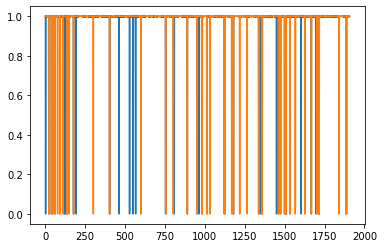

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.3, random_state=42)
regr_1 = DecisionTreeRegressor(max_depth=32)
regr_1.fit(X_train, y_train[:,5])
y_1 = regr_1.predict(X_test)
plt.plot(y_1)
plt.plot(y_test[:,5])
err1 = mean_squared_error(y_test[:,5],y_1)
print(err1)

# Results

In [7]:
criterias_lst = ["MAE", "MSE", "RMSE", "MAPE"]
fesibility_criterias_lst = ['accuracy', 'f1', 'precision', 'recall']
# criterias = {"MAE":{}, "MSE":{}, "RMSE":{}, "MAPE":{}}
performance = {'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}} #criterias}
result = {'DT':{'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}}, 
          'ADBoost':{'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}}, 
          'GBoost':{'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}}, 
          'RF':{'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}}, 
          'SVR':{'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}}, 
          'MLP':{'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}}, 
          'LSTM':{'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}}}
fesibility_result = {'DT':{'fesibility':{}}, 'ADBoost':{'fesibility':{}}, 
                     'GBoost':{'fesibility':{}}, 'RF':{'fesibility':{}}, 
                     'SVC':{'fesibility':{}}, 'MLP':{'fesibility':{}}, 'LSTM':{'fesibility':{}}}

# DecisionTreeRegressor

# Flight Conditions

In [14]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
print(dataX.shape)
print(dataY.shape)
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')
print(datatestX.shape)
print(datatestY.shape)

(6358, 22)
(6358, 6)
(607, 22)
(607, 6)


In [28]:
scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = DecisionTreeClassifier(max_depth=32)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['DT']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['DT']['fesibility']['f1'] = round(f1, 2)
fesibility_result['DT']['fesibility']['precision'] = round(precision, 2)
fesibility_result['DT']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9894319682959049


In [139]:
scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
               for i in range(datatestX.shape[0])]
    mse = mean_squared_error(datatestY[:,i], clf.predict(datatestX), sample_weight=weights)
    f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
    precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
    recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

    fesibility_result['DT']['fesibility']['accuracy'] = round(acc, 2)
    fesibility_result['DT']['fesibility']['f1'] = round(f1, 2)
    fesibility_result['DT']['fesibility']['precision'] = round(precision, 2)
    fesibility_result['DT']['fesibility']['recall'] = round(recall, 2)
    print(acc)
    
    
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['DT']['flight_conditions']:
            result['DT']['flight_conditions'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['DT']['flight_conditions'][outputs[output_indx]] = {}
            result['DT']['flight_conditions'][outputs[output_indx]][criterias_lst[j]] = err
    
print(best_estimators)

0.0
0.0211
0.0028
299.5606
[DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32)]


(21, 22) (21, 6)
Inference Time 0.03782987594604492s


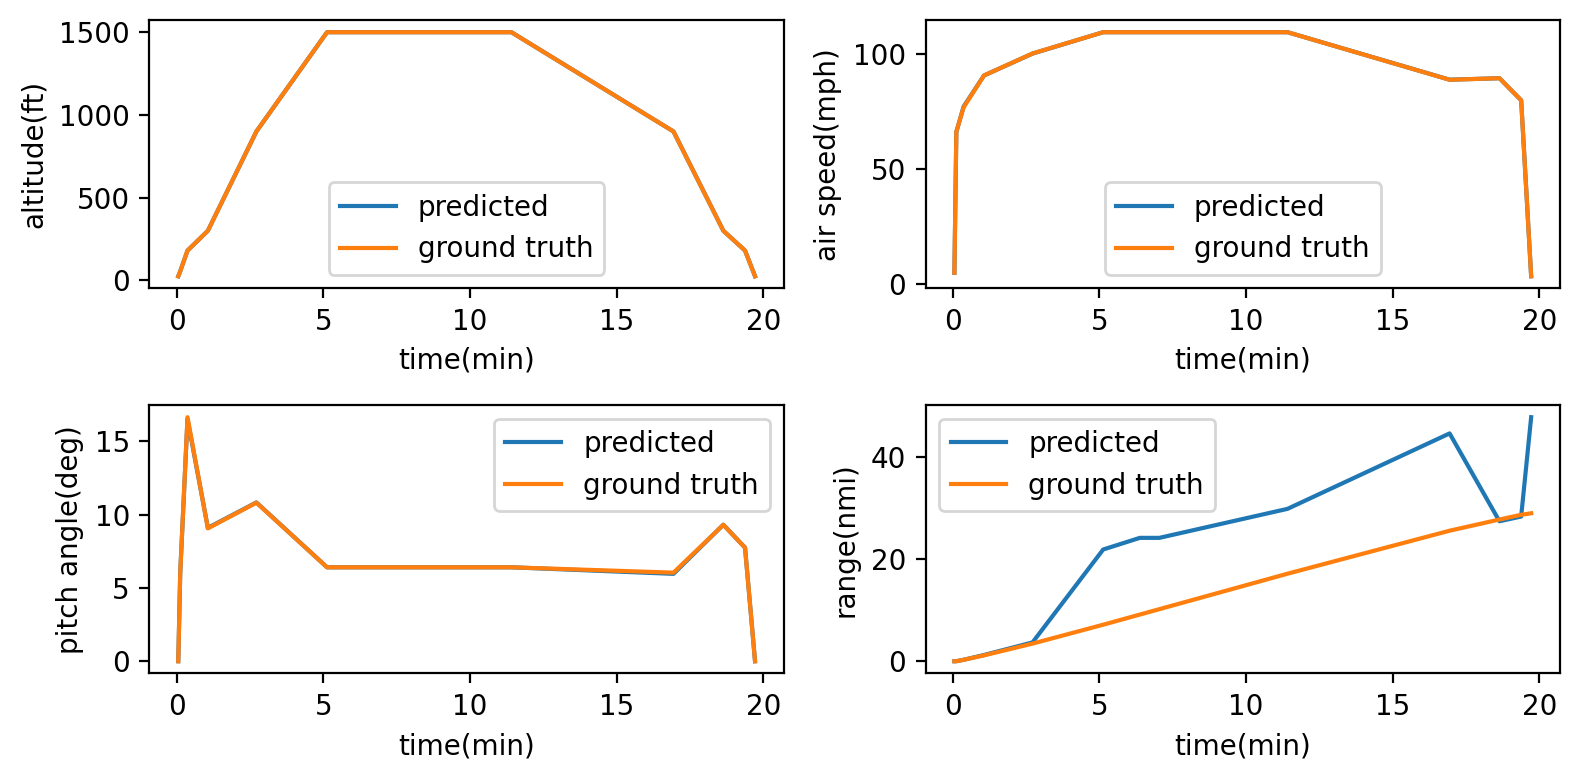

In [140]:
start_time = time.time()
testX, testY = get_data_for_inference('flight_conditions')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
print('Inference Time {}s'.format(time.time()-start_time))
pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
t = testY[:,4]
true_i = [0,1,2,3]#,5]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# Aerodynamic Coefficients

In [78]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('aerodynamic_coefficients')
print(dataY.shape)

(5687, 22)
(5687, 6)


In [79]:
scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['DT']['aerodynamic_coefficients']:
            result['DT']['aerodynamic_coefficients'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['DT']['aerodynamic_coefficients'][outputs[output_indx]] = {}
            result['DT']['aerodynamic_coefficients'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

0.0
0.0
0.0024
0.0001
[DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32)]


(243, 22) (243, 6)
(243, 6) (243, 4)


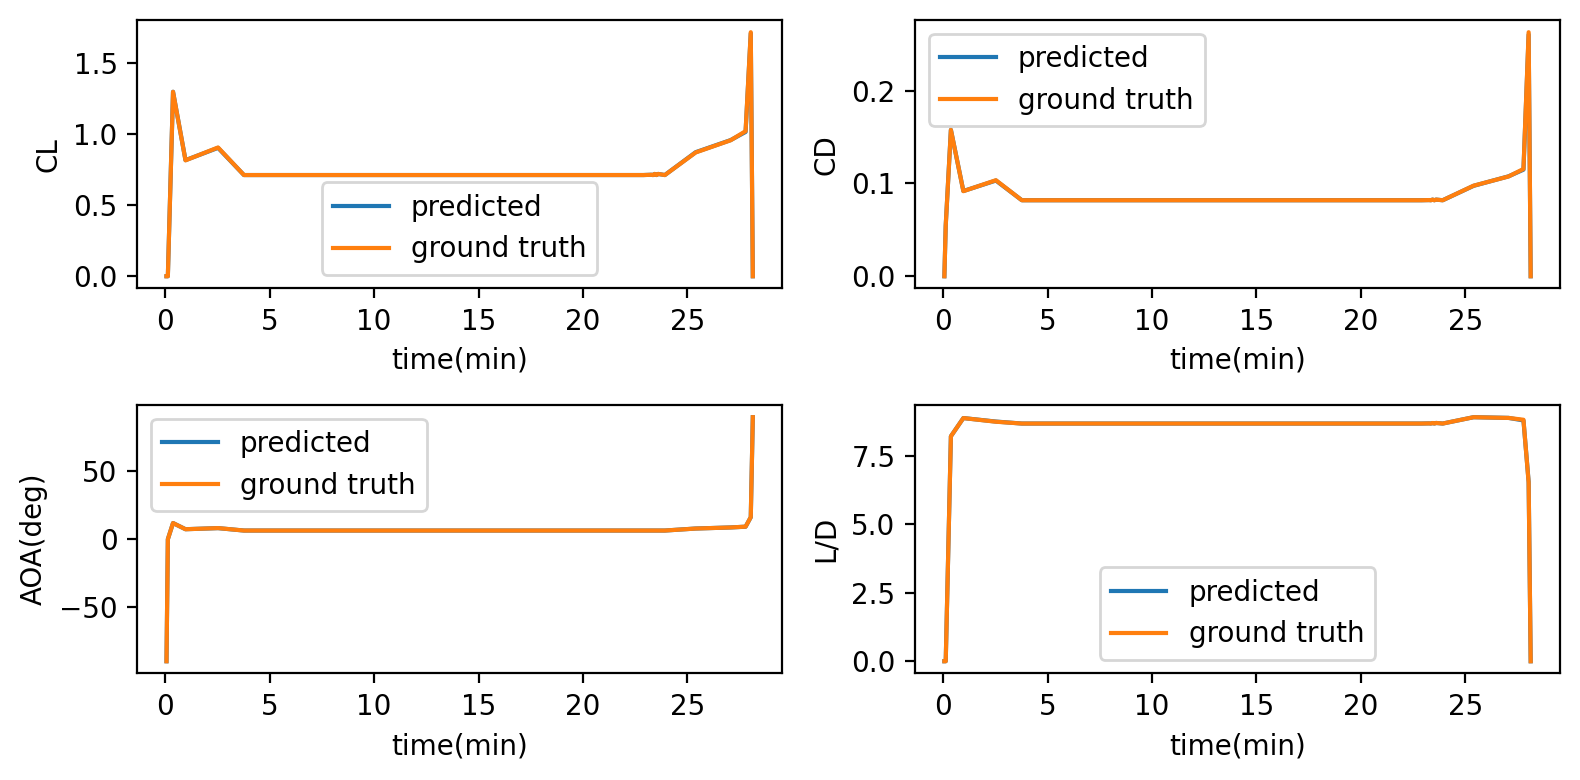

In [80]:
testX, testY = get_data_for_inference('aerodynamic_coefficients')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
t = testY[:,4]
true_i = [0,1,2,3]#,5]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# Aircraft Electronics

In [81]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('aircraft_electronics')
print(dataY.shape)

(5687, 22)
(5687, 11)


In [82]:
scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8]):#,10]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['DT']['aircraft_electronics']:
            result['DT']['aircraft_electronics'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['DT']['aircraft_electronics'][outputs[output_indx]] = {}
            result['DT']['aircraft_electronics'][outputs[output_indx]][criterias_lst[j]] = err
            
print(best_estimators)

0.0232
205.1304
0.0583
268.0153
223.8693
43.8226
0.0984
0.0957
0.9906
[DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32)]


(261, 22) (261, 11)
(261, 11) (261, 9)


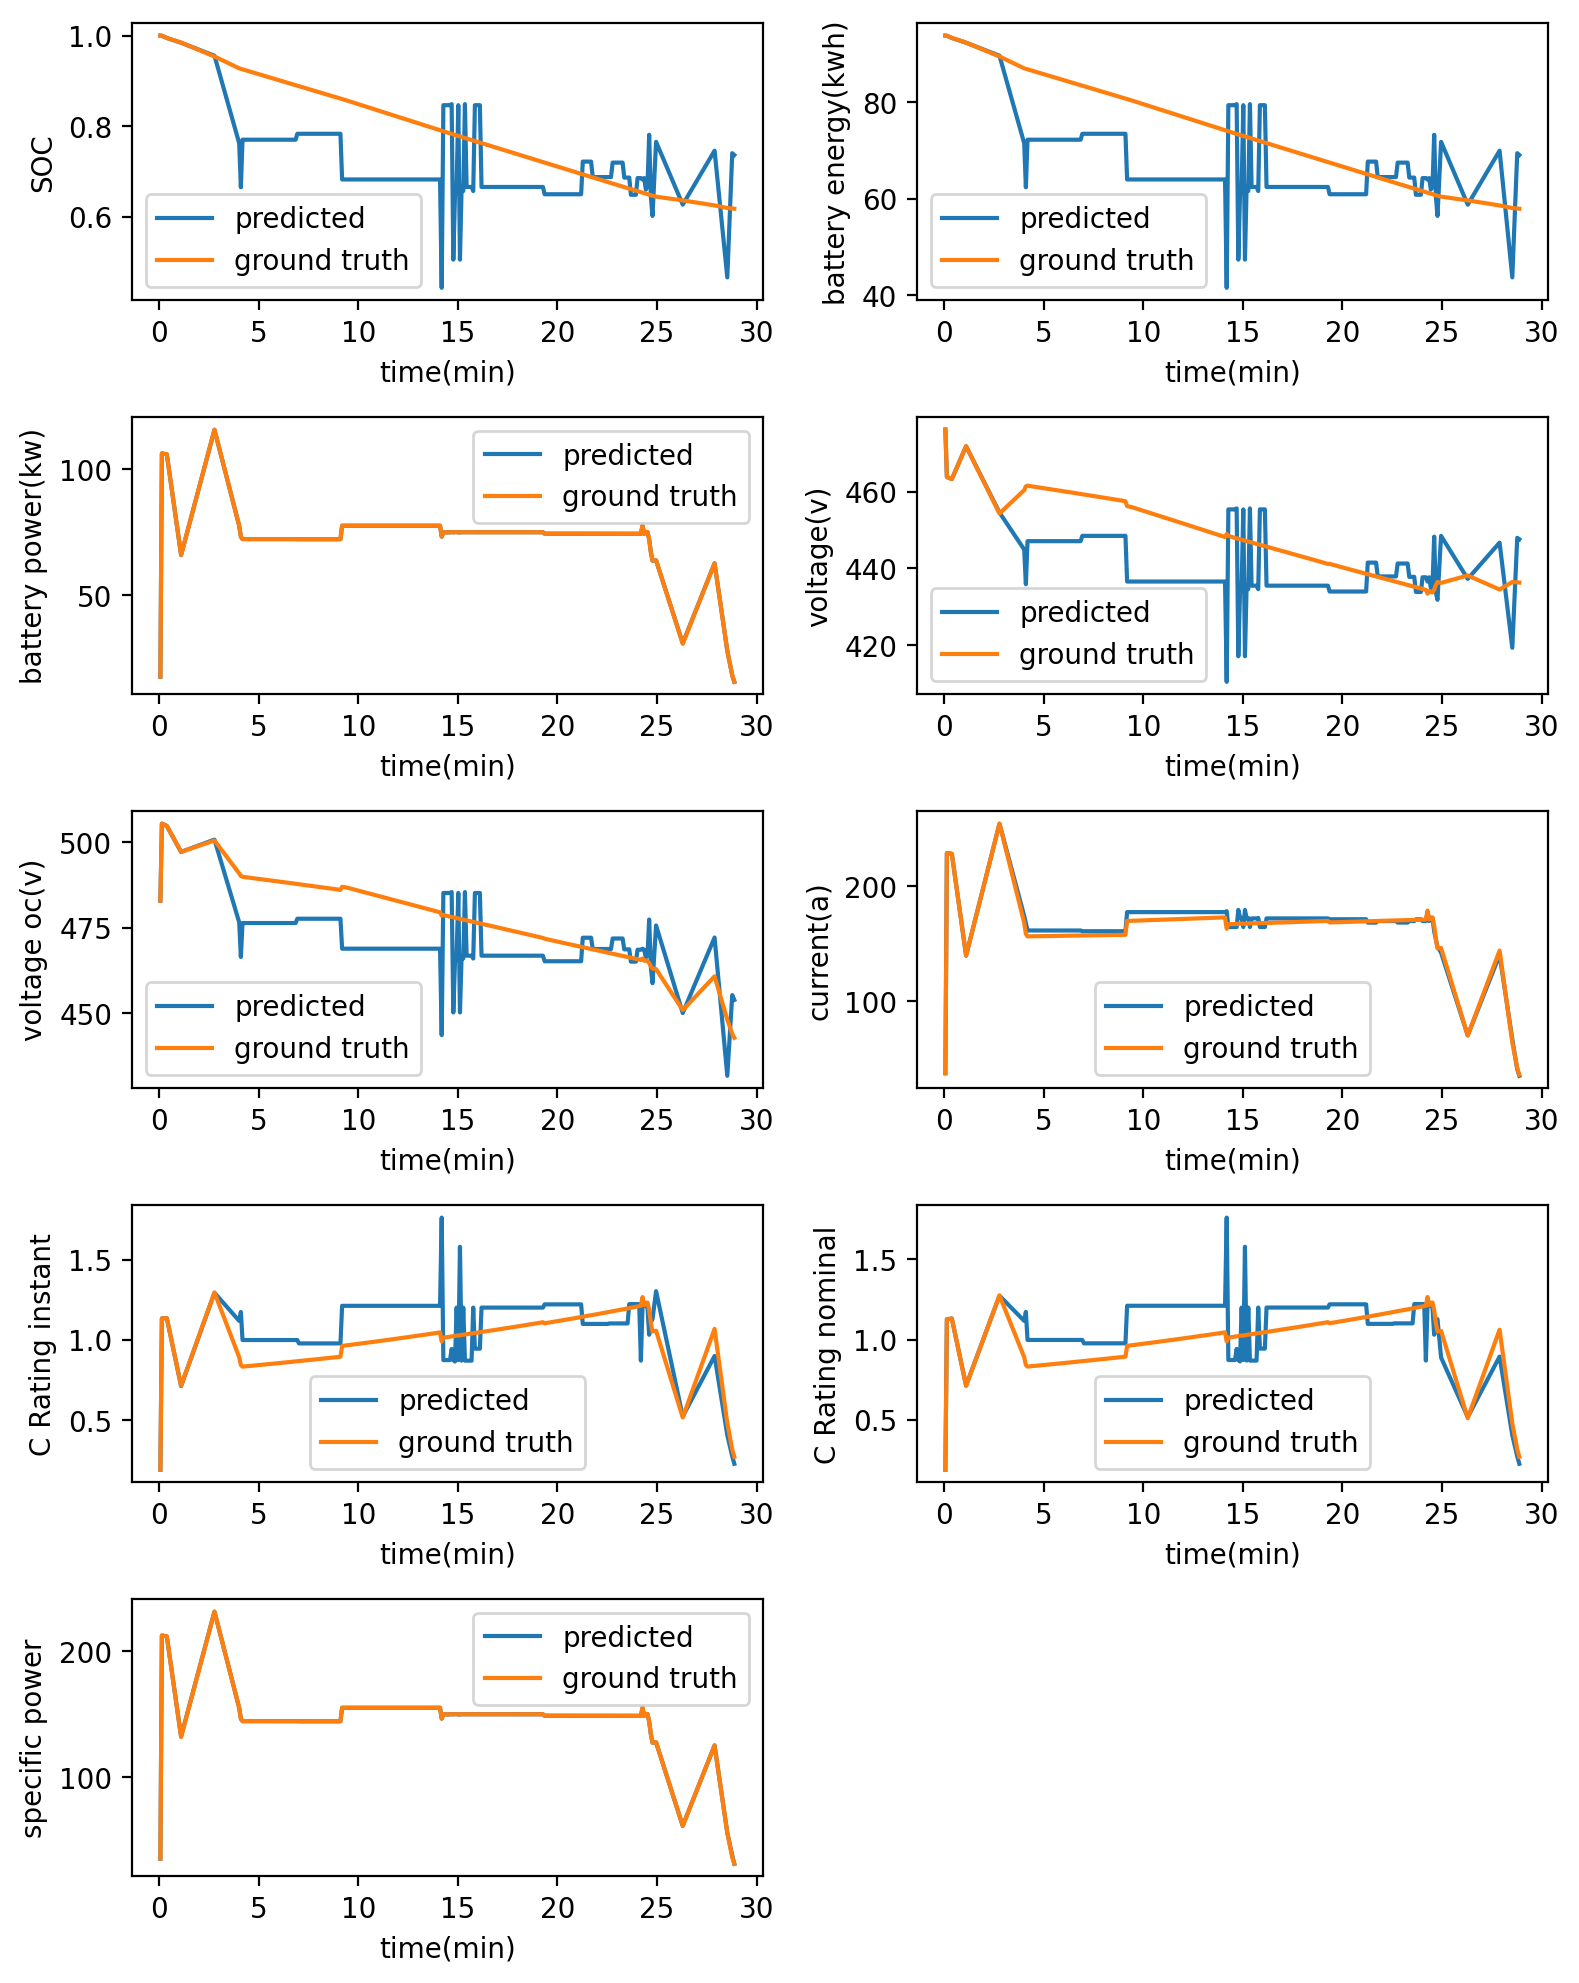

In [83]:
testX, testY = get_data_for_inference('aircraft_electronics')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
t = testY[:,9]
true_i = [0,1,2,3,4,5,6,7,8]#,10]
fig = plt.figure(figsize=(8,10), dpi=200)
for i in range(1,10):
    plt.subplot(5,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# Electric motor and propeller efficiencies 

In [84]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('electric_motor_and_propeller_efficiencies')
print(dataY.shape)

(5687, 22)
(5687, 18)


In [85]:
scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]):#,17]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['DT']['electric_motor_and_propeller_efficiencies']:
            result['DT']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['DT']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]] = {}
            result['DT']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]][criterias_lst[j]] = err
            
print(best_estimators)

0.0013
0.0
8.1378
21.5277
19.6435
0.0
0.0
0.0
0.0019
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32), DecisionTreeRegressor(max_depth=32)]


(21, 22) (21, 18)
(20, 18) (20, 16)


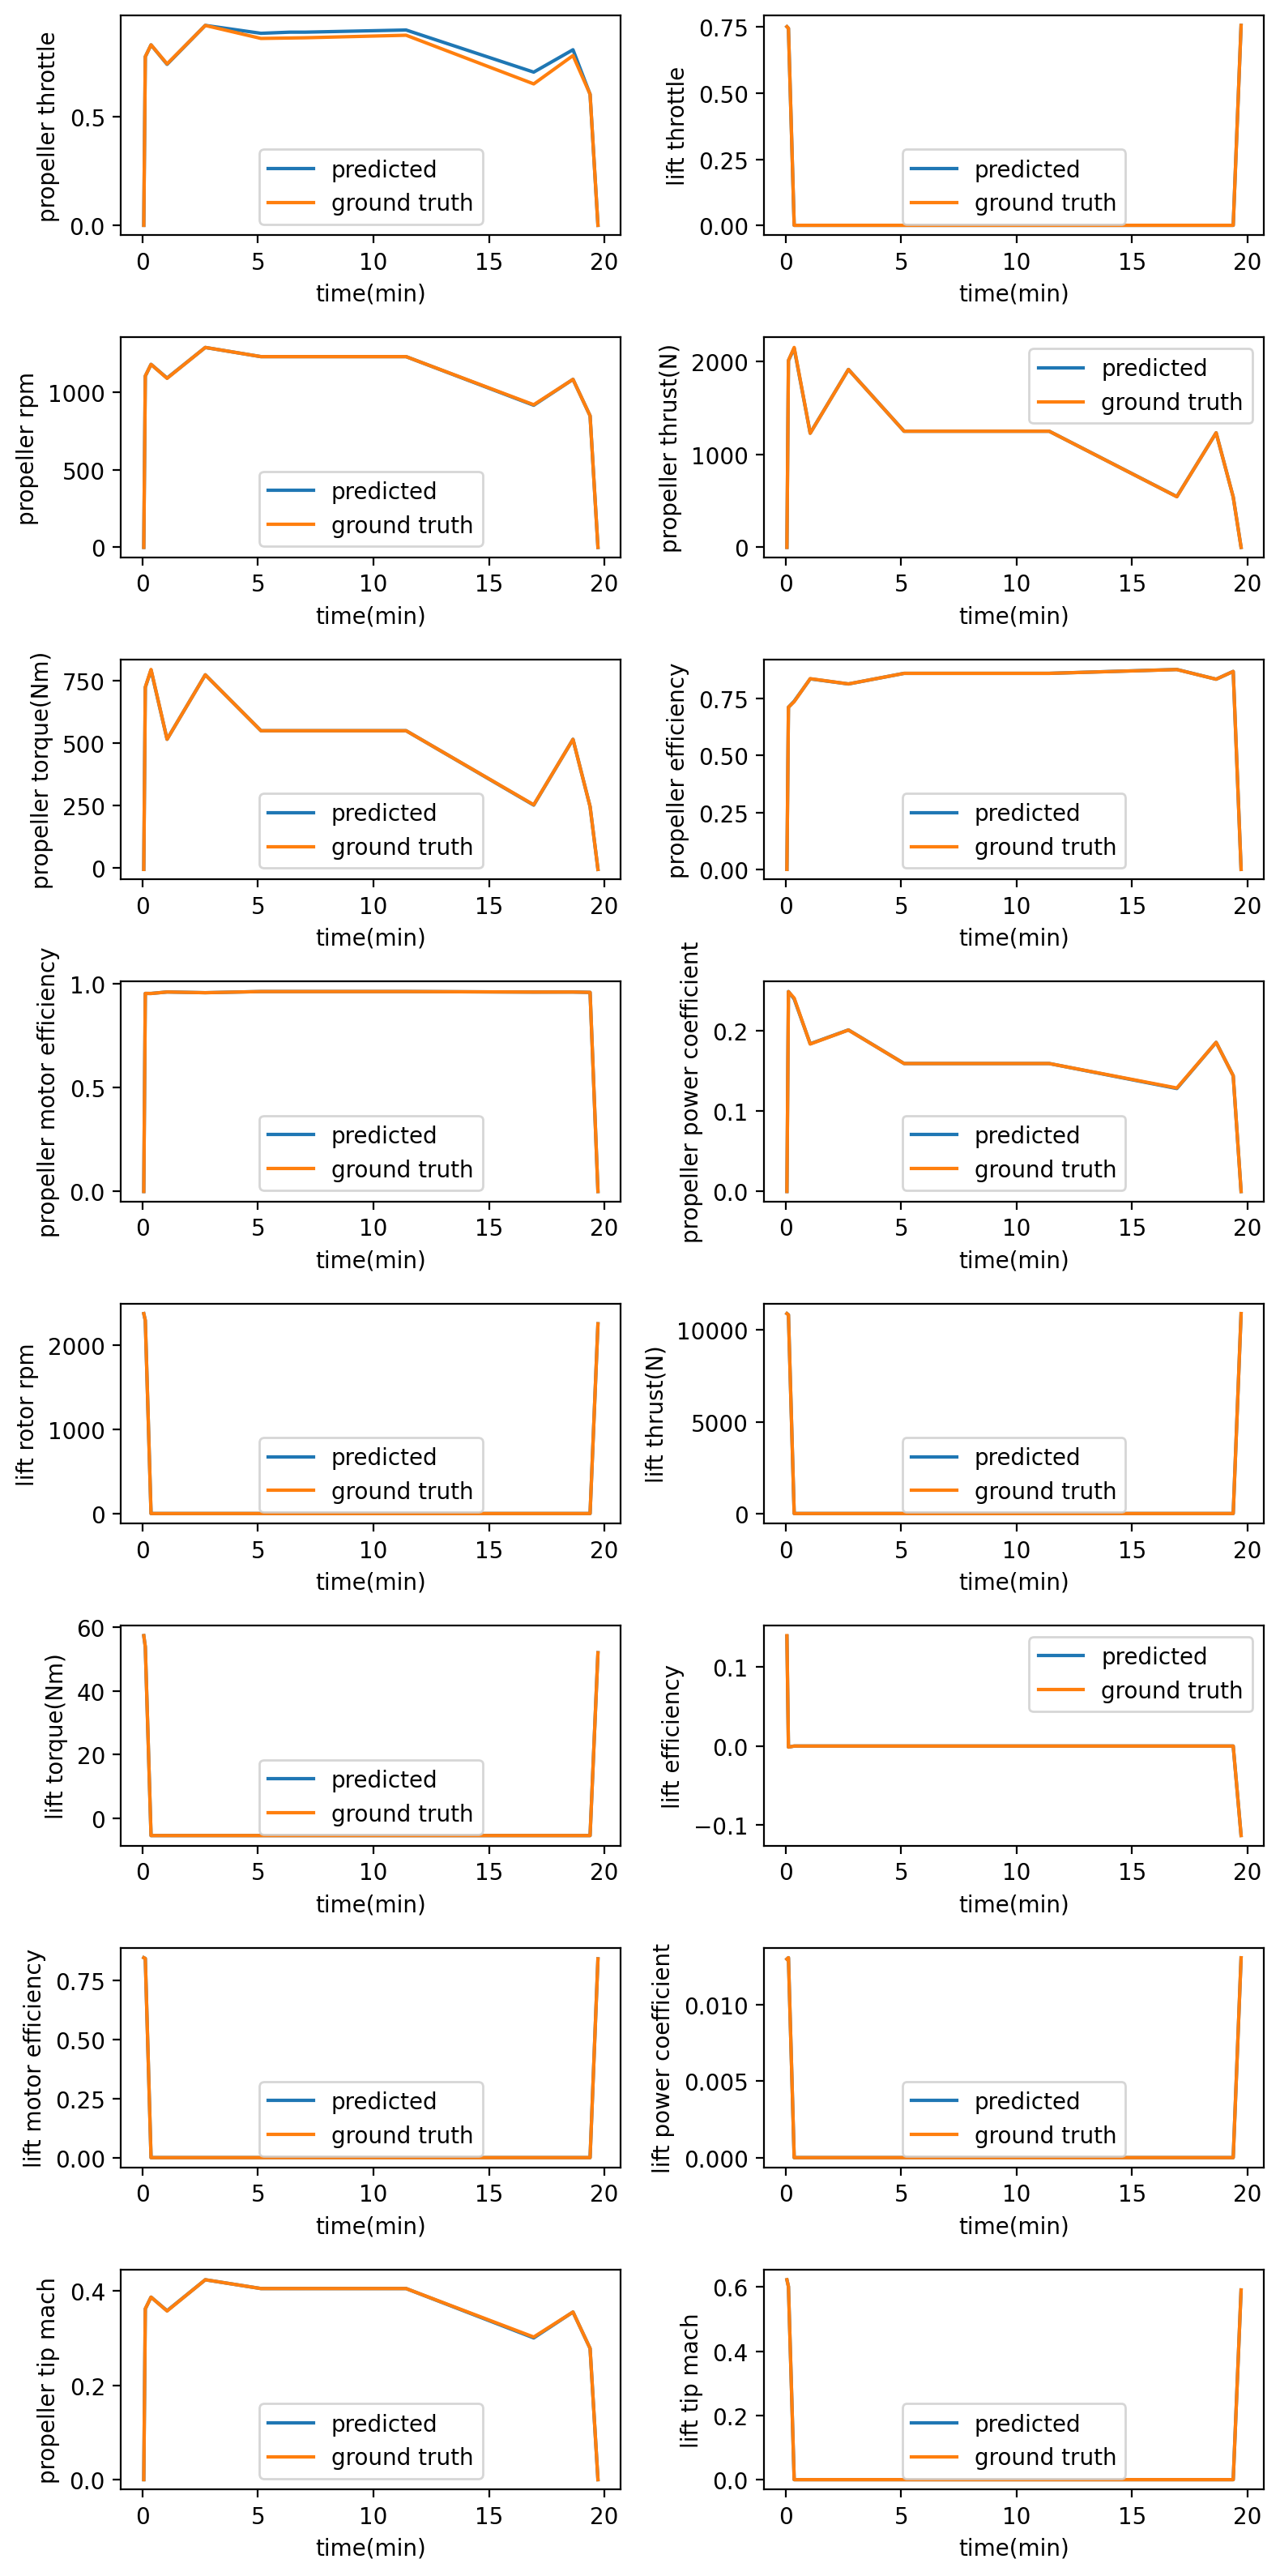

In [86]:
testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
t = testY[:,16]
true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
fig = plt.figure(figsize=(8,16), dpi=200)
for i in range(1,17):
    plt.subplot(8,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# AdaBoostRegressor

# Flight Conditions

In [29]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8), n_estimators=300, 
                         random_state=np.random.RandomState(1))
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['ADBoost']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['ADBoost']['fesibility']['f1'] = round(f1, 2)
fesibility_result['ADBoost']['fesibility']['precision'] = round(precision, 2)
fesibility_result['ADBoost']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9947159841479525


(5687, 22)
(5687, 6)
0.0
0.0215
0.0038
227.6418
[AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13E000240), AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13D81C840), AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13E000340), AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13D81CC40)]
(23, 22) (23, 6)


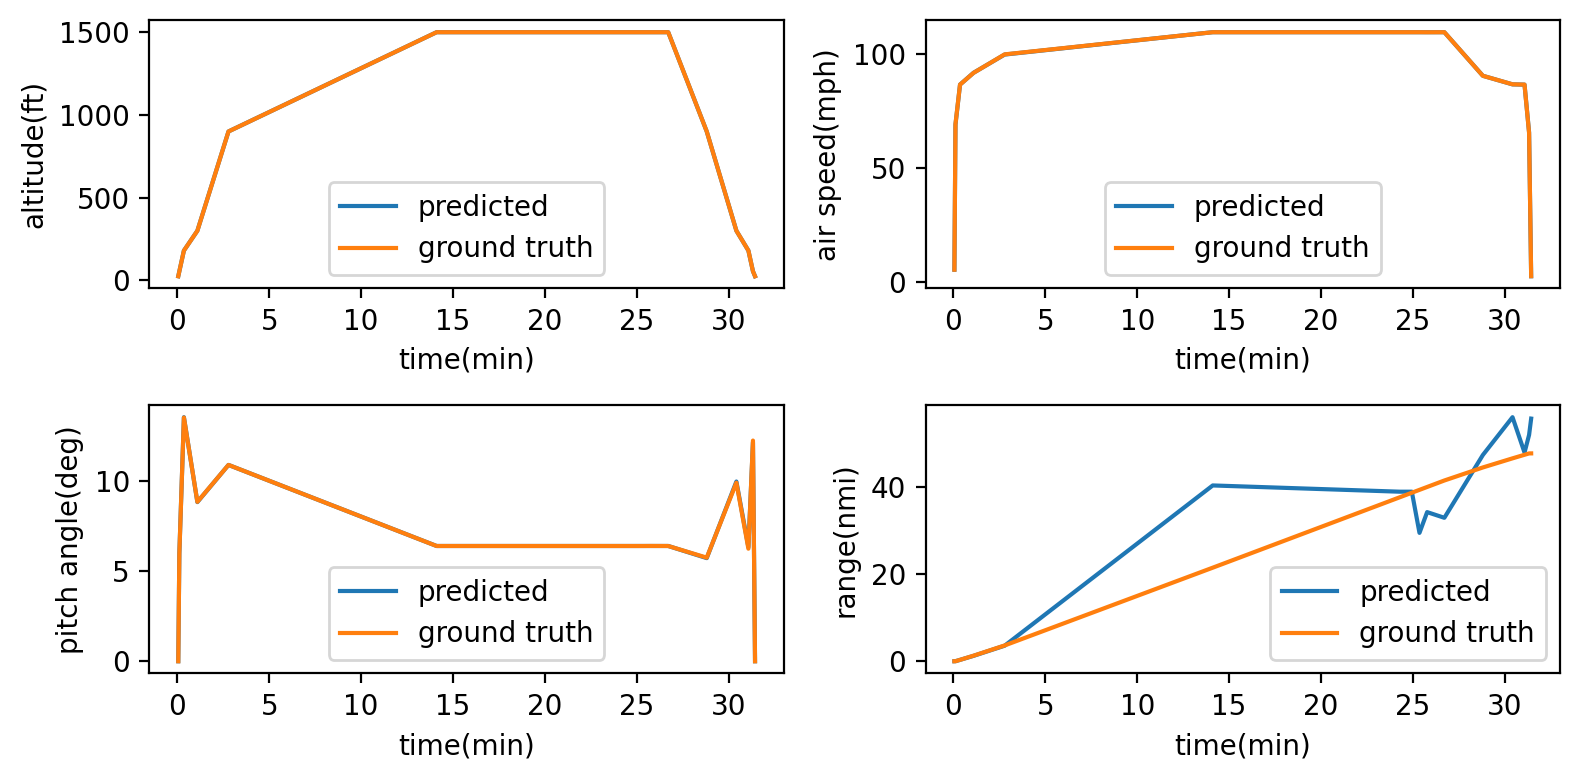

In [124]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('flight_conditions')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
rng = np.random.RandomState(1)
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
for output_indx, i in enumerate([0,1,2,3]): #,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, random_state=rng)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['ADBoost']['flight_conditions']:
            result['ADBoost']['flight_conditions'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['ADBoost']['flight_conditions'][outputs[output_indx]] = {}
            result['ADBoost']['flight_conditions'][outputs[output_indx]][criterias_lst[j]] = err
            
print(best_estimators)

testX, testY = get_data_for_inference('flight_conditions')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
t = testY[:,4]
true_i = [0,1,2,3]#,5]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# Aerodynamic Coefficients

(5687, 22)
(5687, 6)
0.0
0.0
0.0032
0.0002
[AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13D81C740), AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13DEFB340), AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13DEFB440), AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13DEFB540)]
(29, 22) (29, 6)
(29, 6) (29, 4)


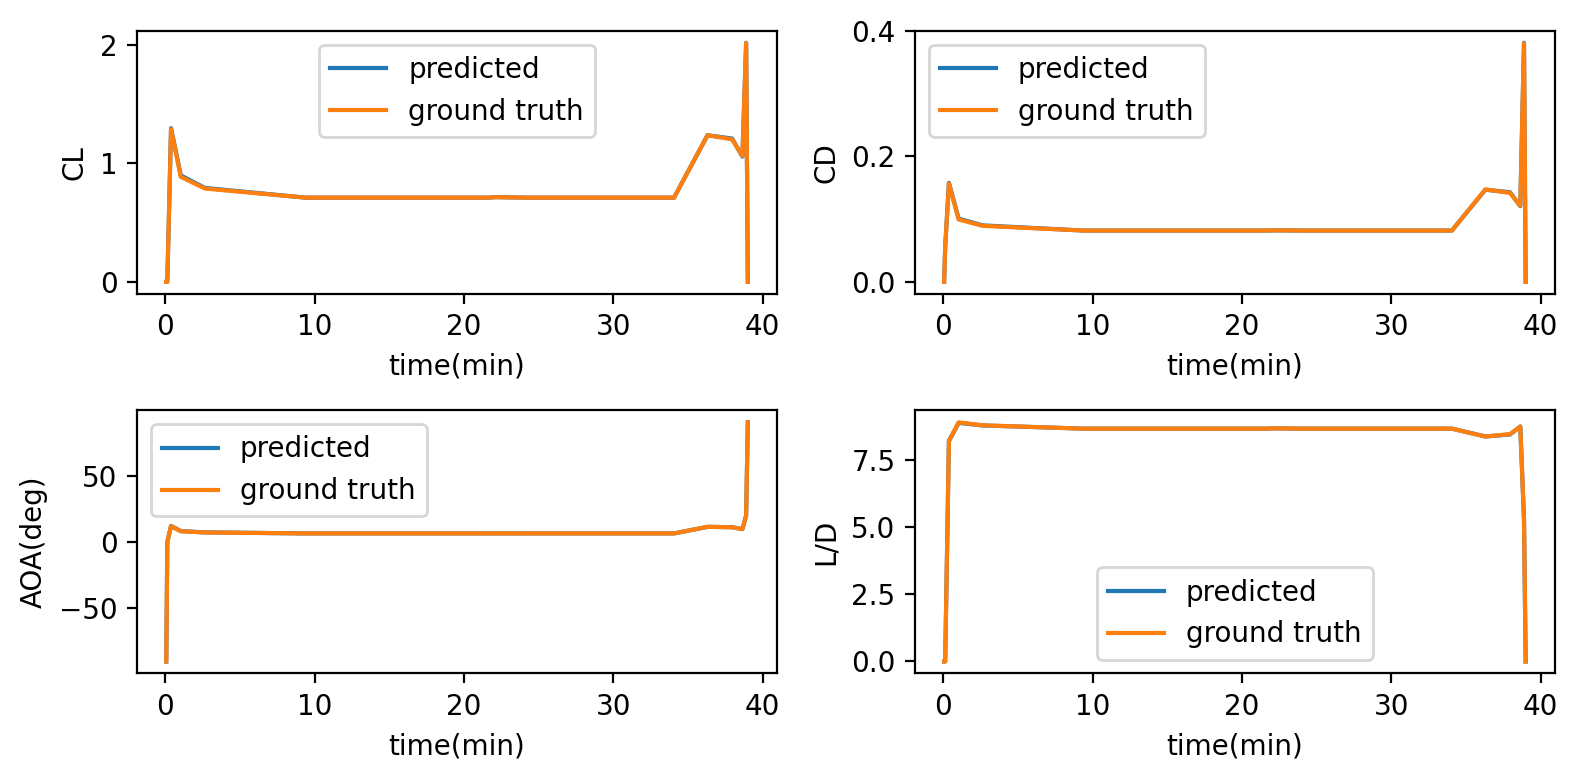

In [89]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('aerodynamic_coefficients')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, 
                             random_state=np.random.RandomState(1))
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['ADBoost']['aerodynamic_coefficients']:
            result['ADBoost']['aerodynamic_coefficients'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['ADBoost']['aerodynamic_coefficients'][outputs[output_indx]] = {}
            result['ADBoost']['aerodynamic_coefficients'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('aerodynamic_coefficients')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
t = testY[:,4]
true_i = [0,1,2,3]#,5]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# Aircraft Electronics

(5687, 22)
(5687, 11)
0.0179
158.8432
0.0805
208.7094
181.7589
44.4535
0.1401
0.1007
0.3199
[AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13D81C040), AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13DEFB040), AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13DEFB140), AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13DEFB440), AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13DEFB340), AdaBoostRegressor(base_estimator=Deci

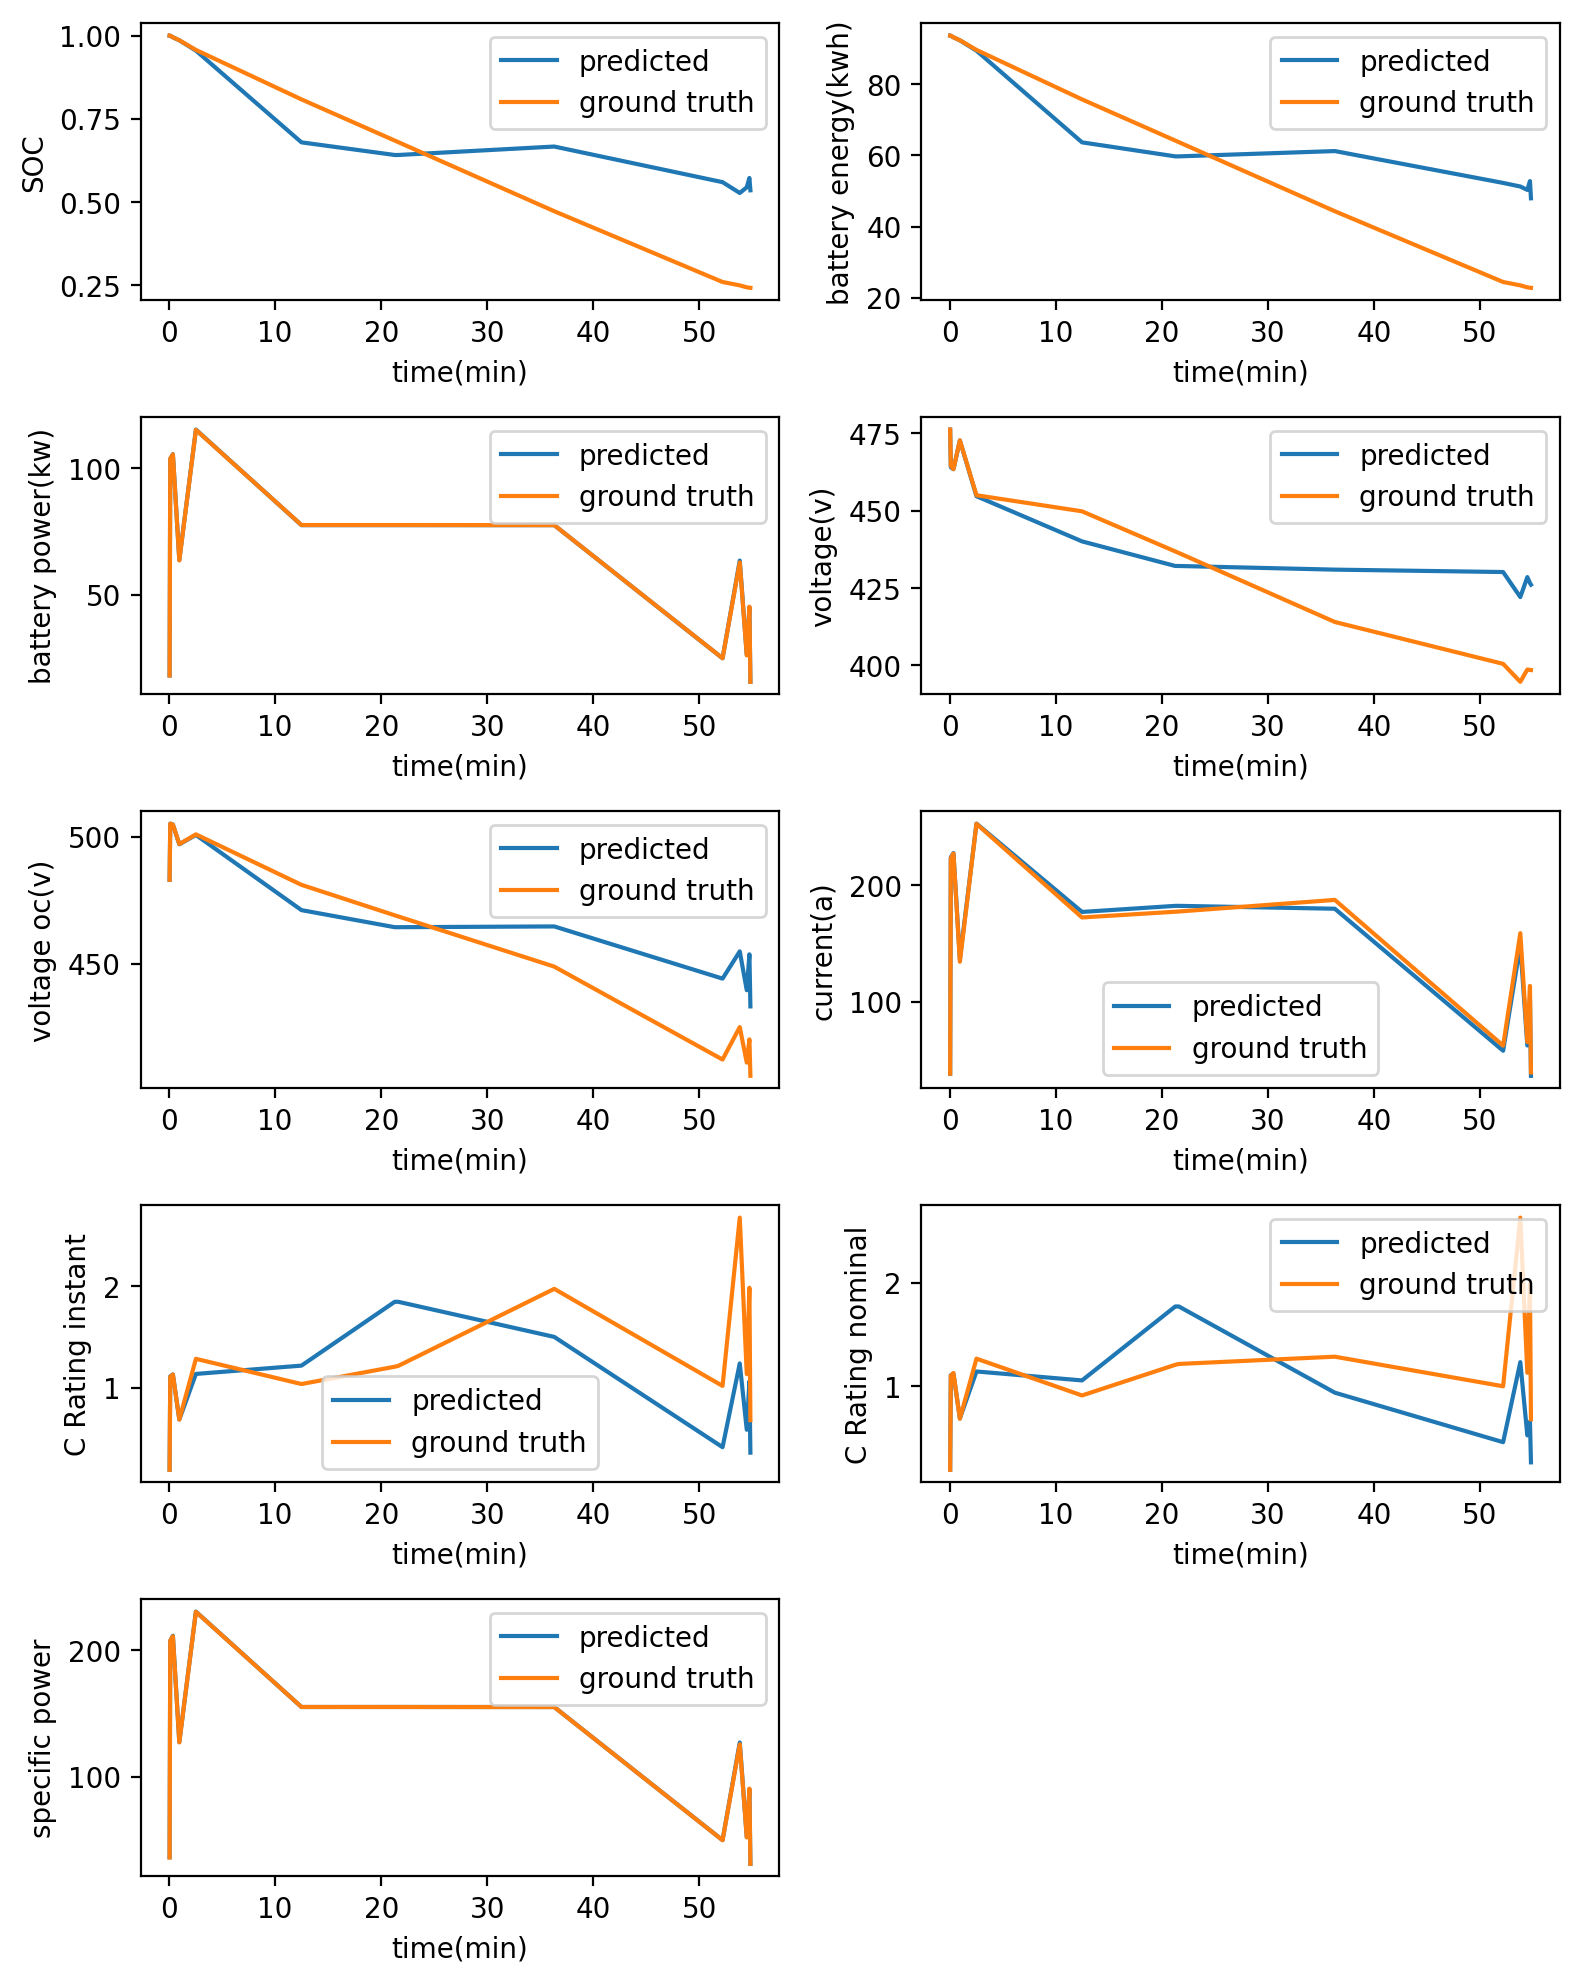

In [90]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('aircraft_electronics')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8]):#,10]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, 
                             random_state=np.random.RandomState(1))
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['ADBoost']['aircraft_electronics']:
            result['ADBoost']['aircraft_electronics'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['ADBoost']['aircraft_electronics'][outputs[output_indx]] = {}
            result['ADBoost']['aircraft_electronics'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('aircraft_electronics')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
t = testY[:,9]
true_i = [0,1,2,3,4,5,6,7,8]#,10]
fig = plt.figure(figsize=(8,10), dpi=200)
for i in range(1,10):
    plt.subplot(5,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# Electric motor and propeller efficiencies

(5687, 22)
(5687, 18)
0.0009
0.0
8.1016
54.8552
45.425
0.0
0.0
0.0
0.002
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13D81CD40), AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13DEFB040), AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13DEFB140), AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13D81C840), AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13D81CC40), AdaBoostRegressor(base_estim

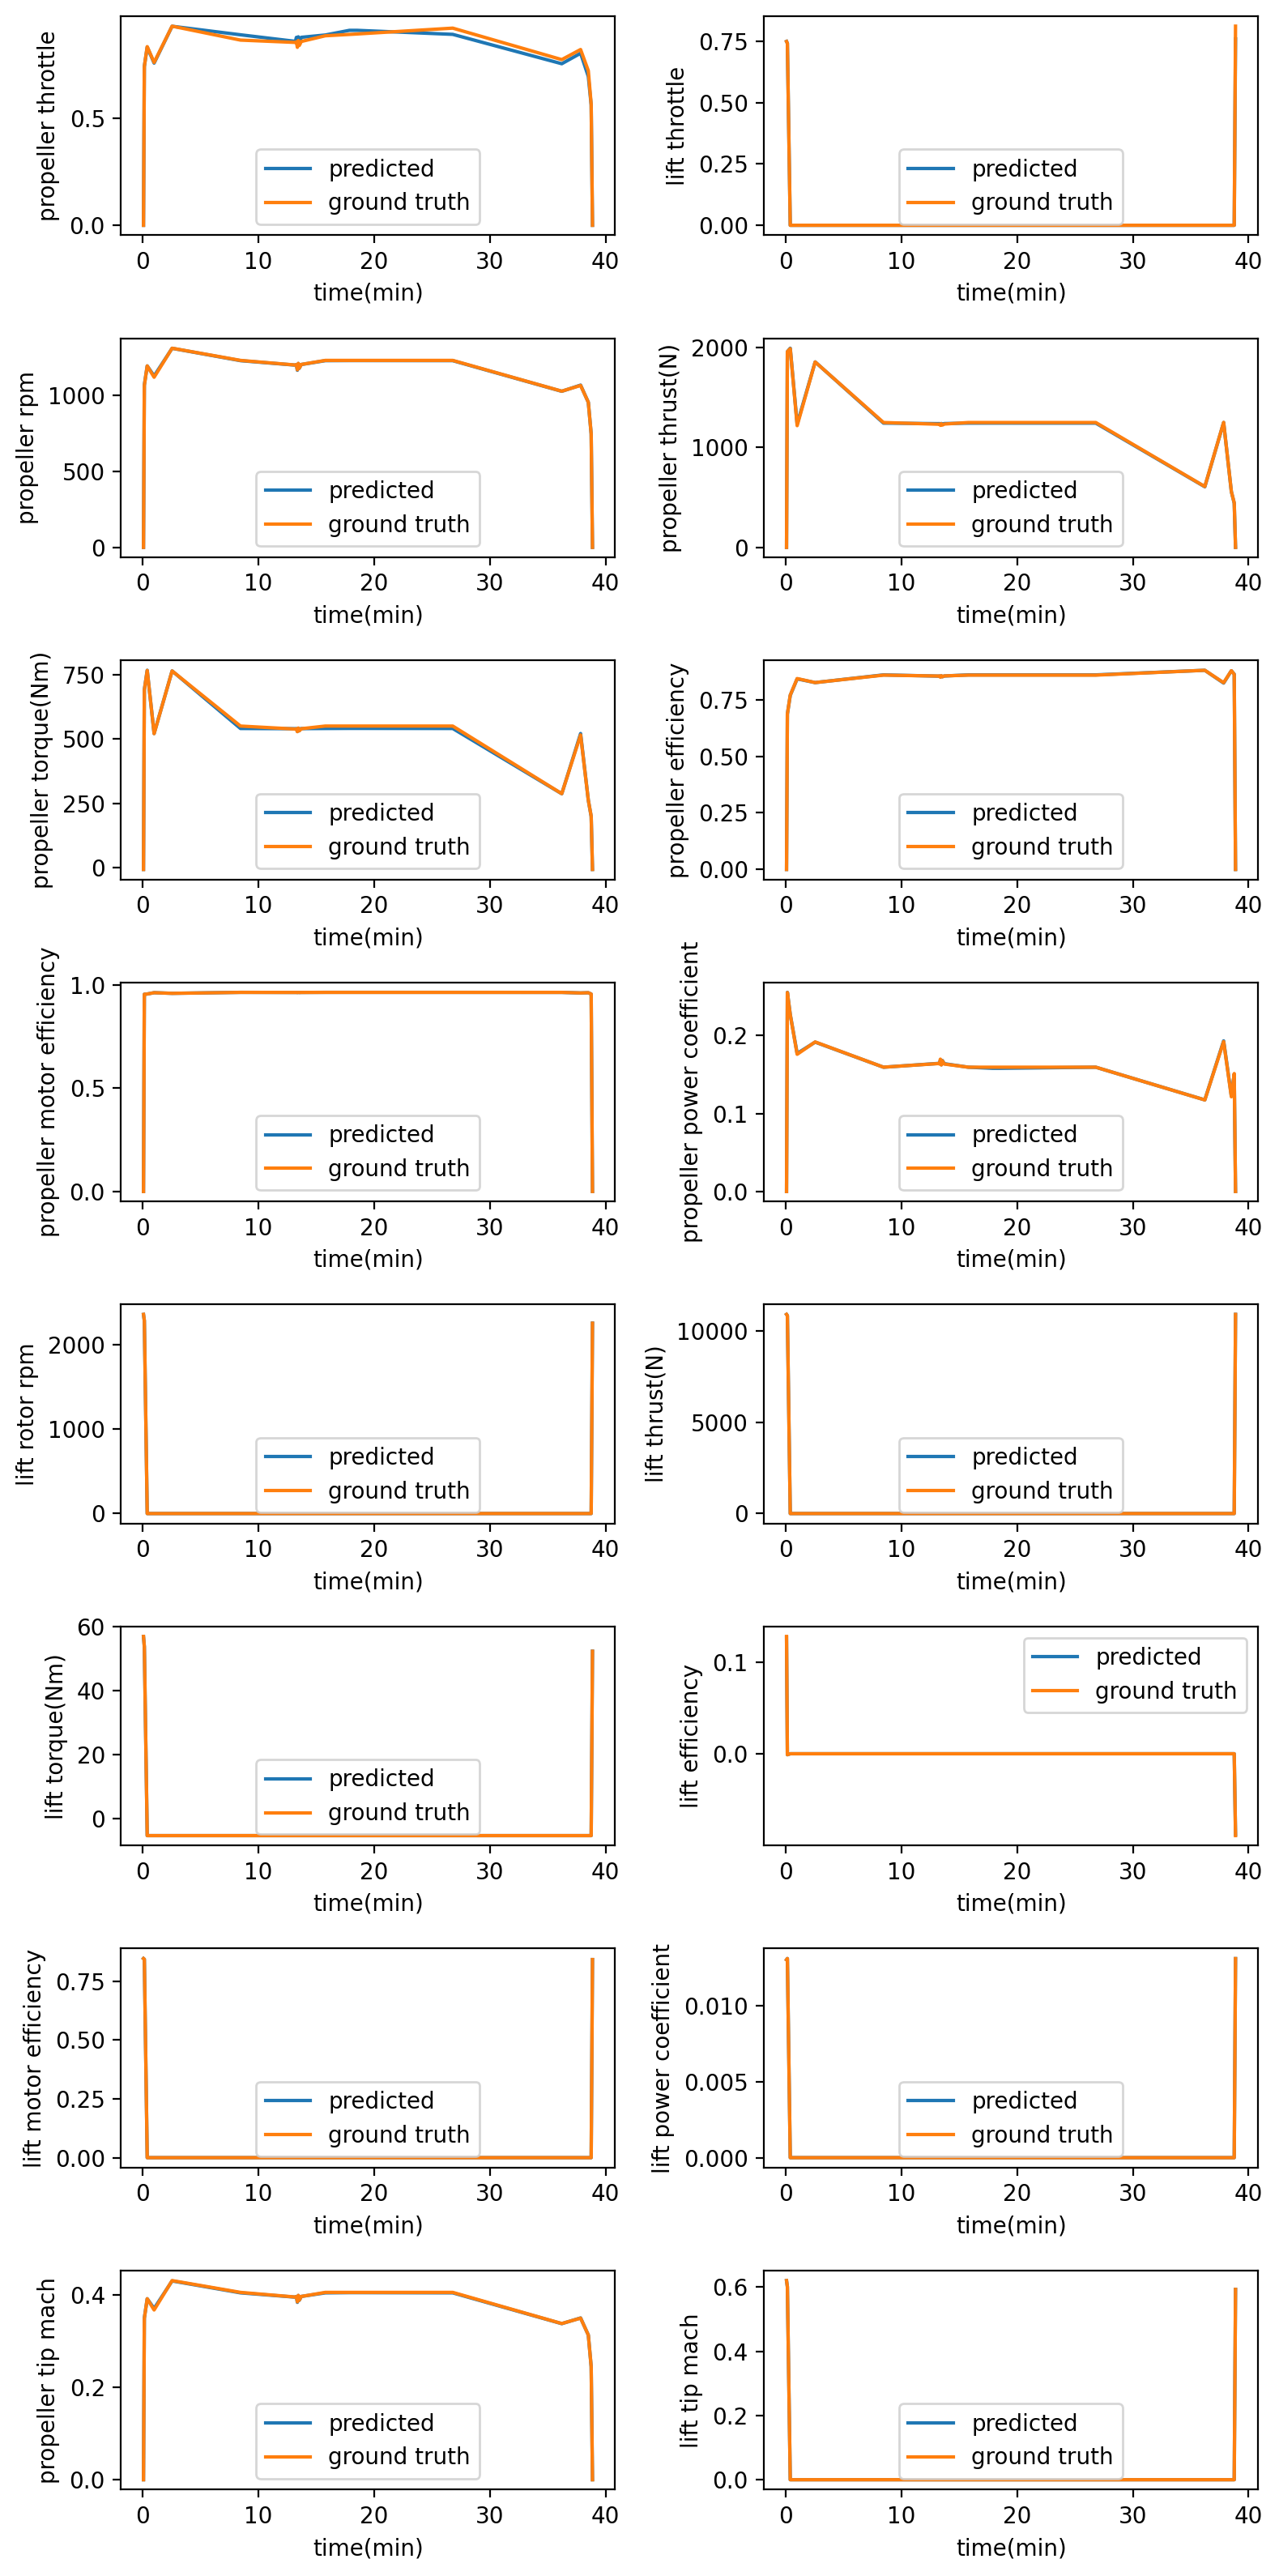

In [91]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('electric_motor_and_propeller_efficiencies')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]):#,17]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, 
                             random_state=np.random.RandomState(1))
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['ADBoost']['electric_motor_and_propeller_efficiencies']:
            result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]] = {}
            result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]][criterias_lst[j]] = err
        
print(best_estimators)

testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
t = testY[:,16]
true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
fig = plt.figure(figsize=(8,16), dpi=200)
for i in range(1,17):
    plt.subplot(8,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# GradientBoostingRegressor

# Flight Conditions

In [30]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = GradientBoostingClassifier(random_state=0)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['GBoost']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['GBoost']['fesibility']['f1'] = round(f1, 2)
fesibility_result['GBoost']['fesibility']['precision'] = round(precision, 2)
fesibility_result['GBoost']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9894319682959049


(5687, 22)
(5687, 6)
0.0022
0.034
0.0121
169.0888
[GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0)]
(18, 22) (18, 6)


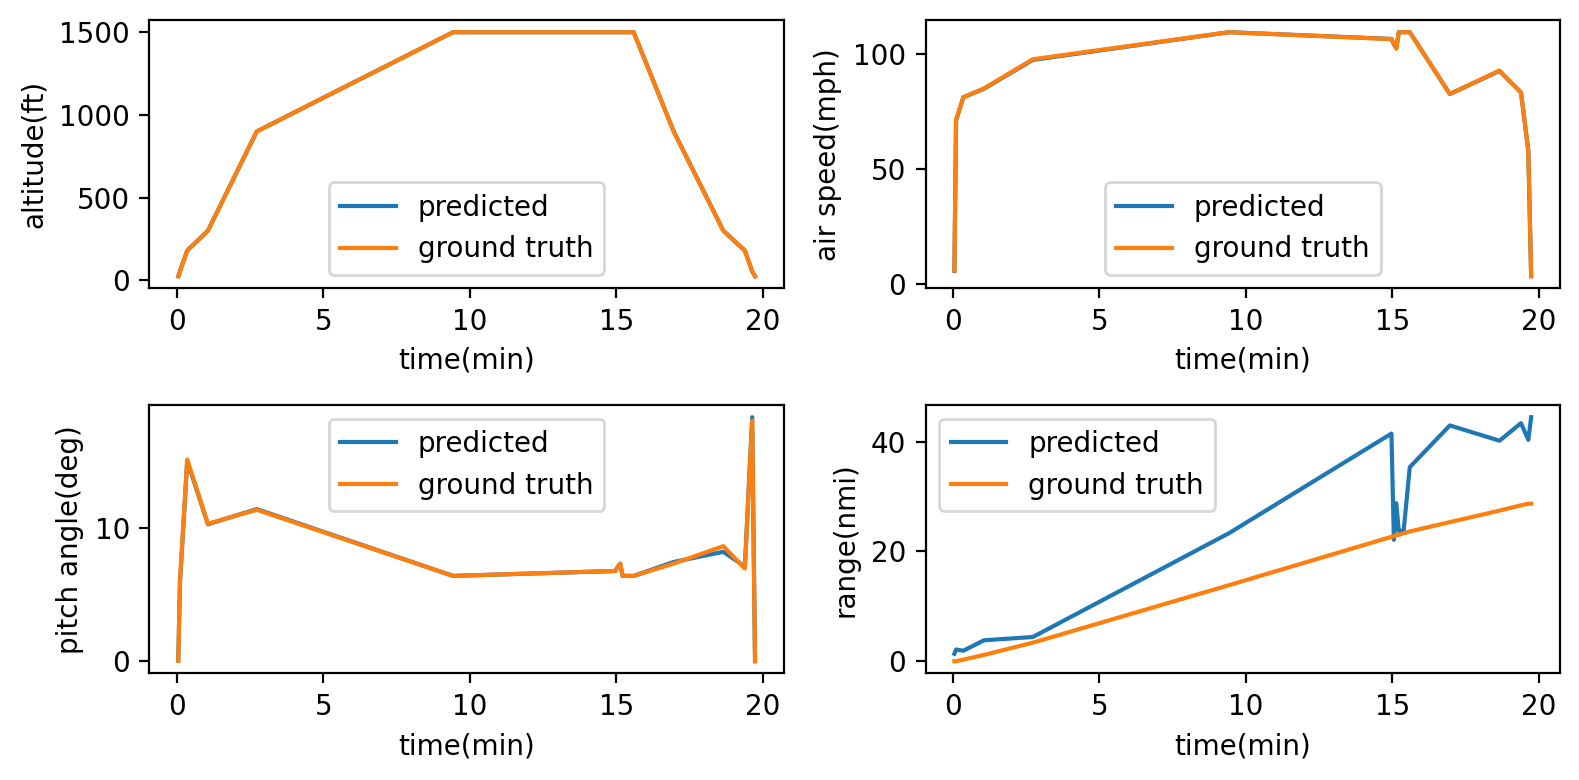

In [126]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('flight_conditions')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = GradientBoostingRegressor(random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['GBoost']['flight_conditions']:
            result['GBoost']['flight_conditions'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['GBoost']['flight_conditions'][outputs[output_indx]] = {}
            result['GBoost']['flight_conditions'][outputs[output_indx]][criterias_lst[j]] = err

print(best_estimators)

testX, testY = get_data_for_inference('flight_conditions')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
t = testY[:,4]
true_i = [0,1,2,3]#,5]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# Aerodynamic Coefficients

(5687, 22)
(5687, 6)
0.0
0.0
0.0177
0.0002
[GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0)]
(29, 22) (29, 6)
(29, 6) (29, 4)


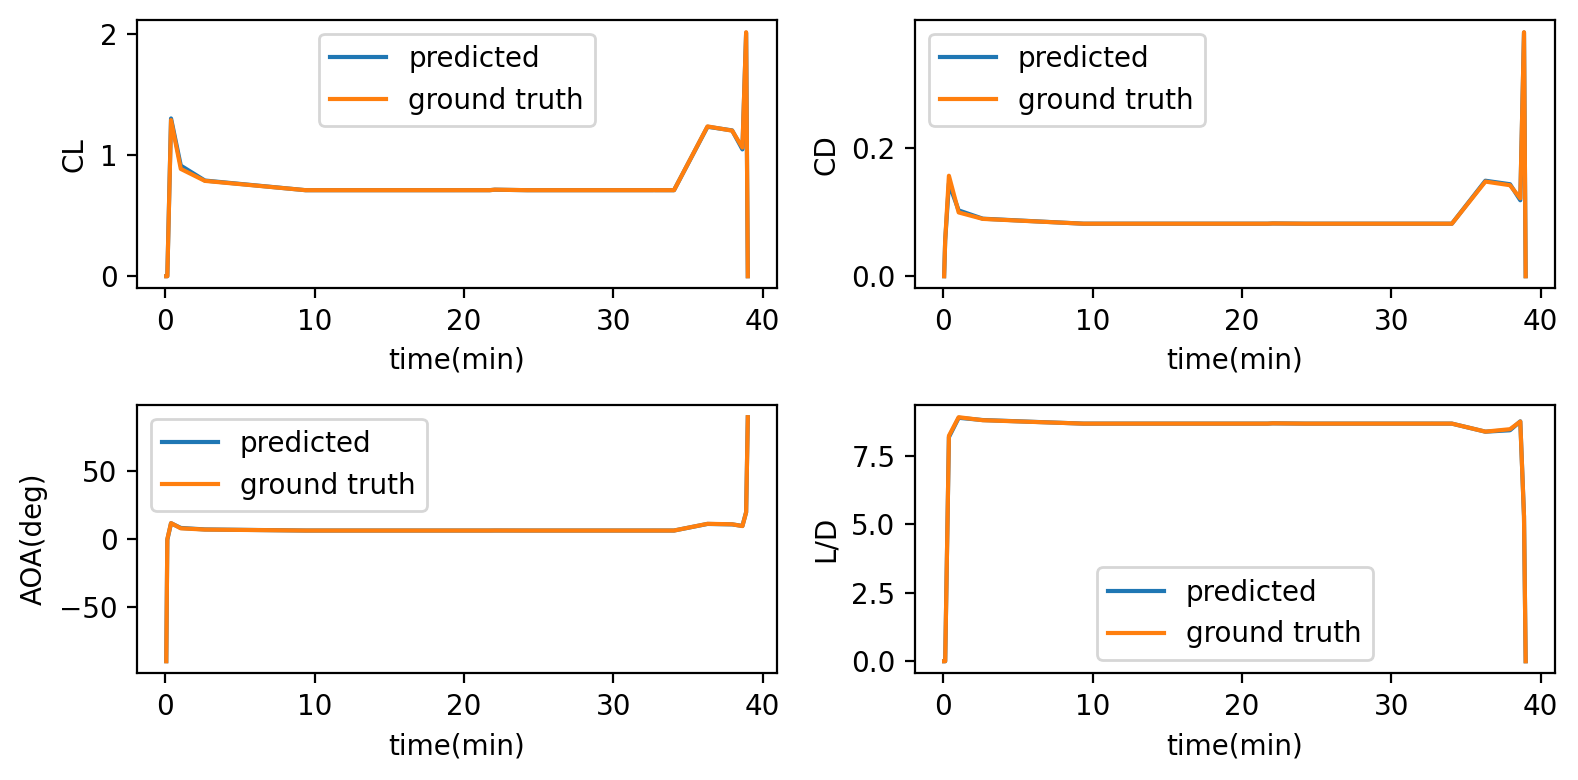

In [94]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('aerodynamic_coefficients')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = GradientBoostingRegressor(random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['GBoost']['aerodynamic_coefficients']:
            result['GBoost']['aerodynamic_coefficients'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['GBoost']['aerodynamic_coefficients'][outputs[output_indx]] = {}
            result['GBoost']['aerodynamic_coefficients'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('aerodynamic_coefficients')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
t = testY[:,4]
true_i = [0,1,2,3]#,5]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# Aircraft Electronics

(5687, 22)
(5687, 11)
0.0131
115.0643
0.5063
150.0054
125.9014
29.0129
0.0538
0.0543
2.0178
[GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0)]
(256, 22) (256, 11)
(256, 11) (256, 9)


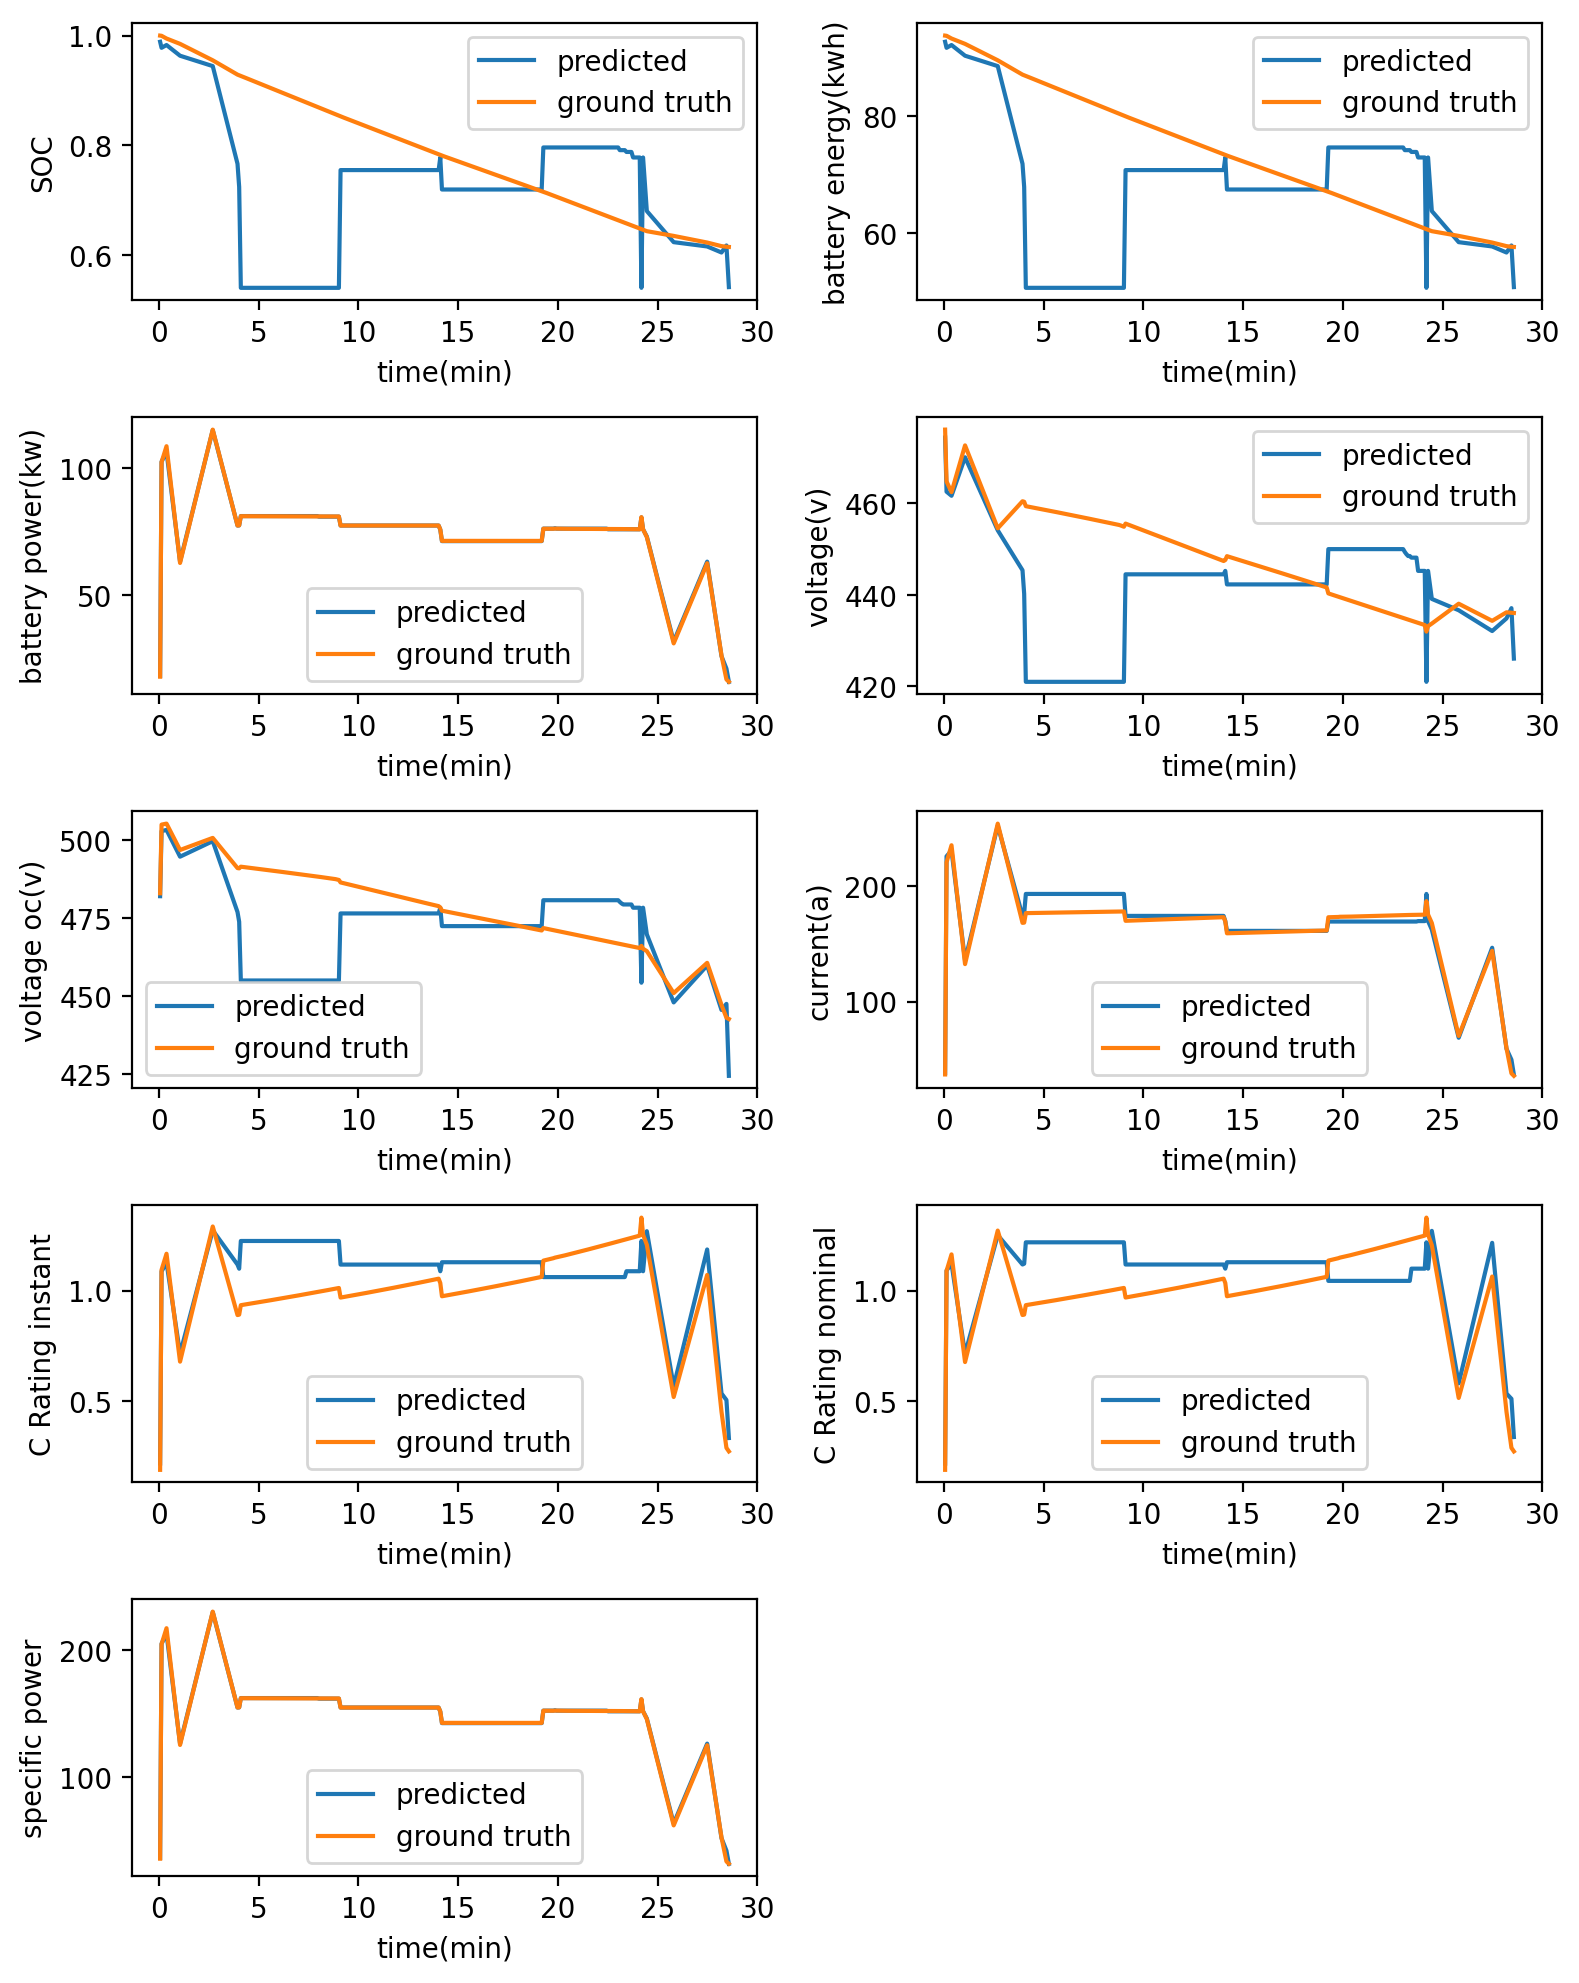

In [95]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('aircraft_electronics')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8]):#,10]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = GradientBoostingRegressor(random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['GBoost']['aircraft_electronics']:
            result['GBoost']['aircraft_electronics'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['GBoost']['aircraft_electronics'][outputs[output_indx]] = {}
            result['GBoost']['aircraft_electronics'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('aircraft_electronics')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
t = testY[:,9]
true_i = [0,1,2,3,4,5,6,7,8]#,10]
fig = plt.figure(figsize=(8,10), dpi=200)
for i in range(1,10):
    plt.subplot(5,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# Electric motor and propeller efficiencies

(5687, 22)
(5687, 18)
0.0007
0.0
16.8554
347.1965
23.2701
0.0
0.0
0.0
0.0032
0.0035
0.0
0.0
0.0
0.0
0.0
0.0
[GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0)]
(256, 22) (256, 18)
(256, 18) (256, 16)


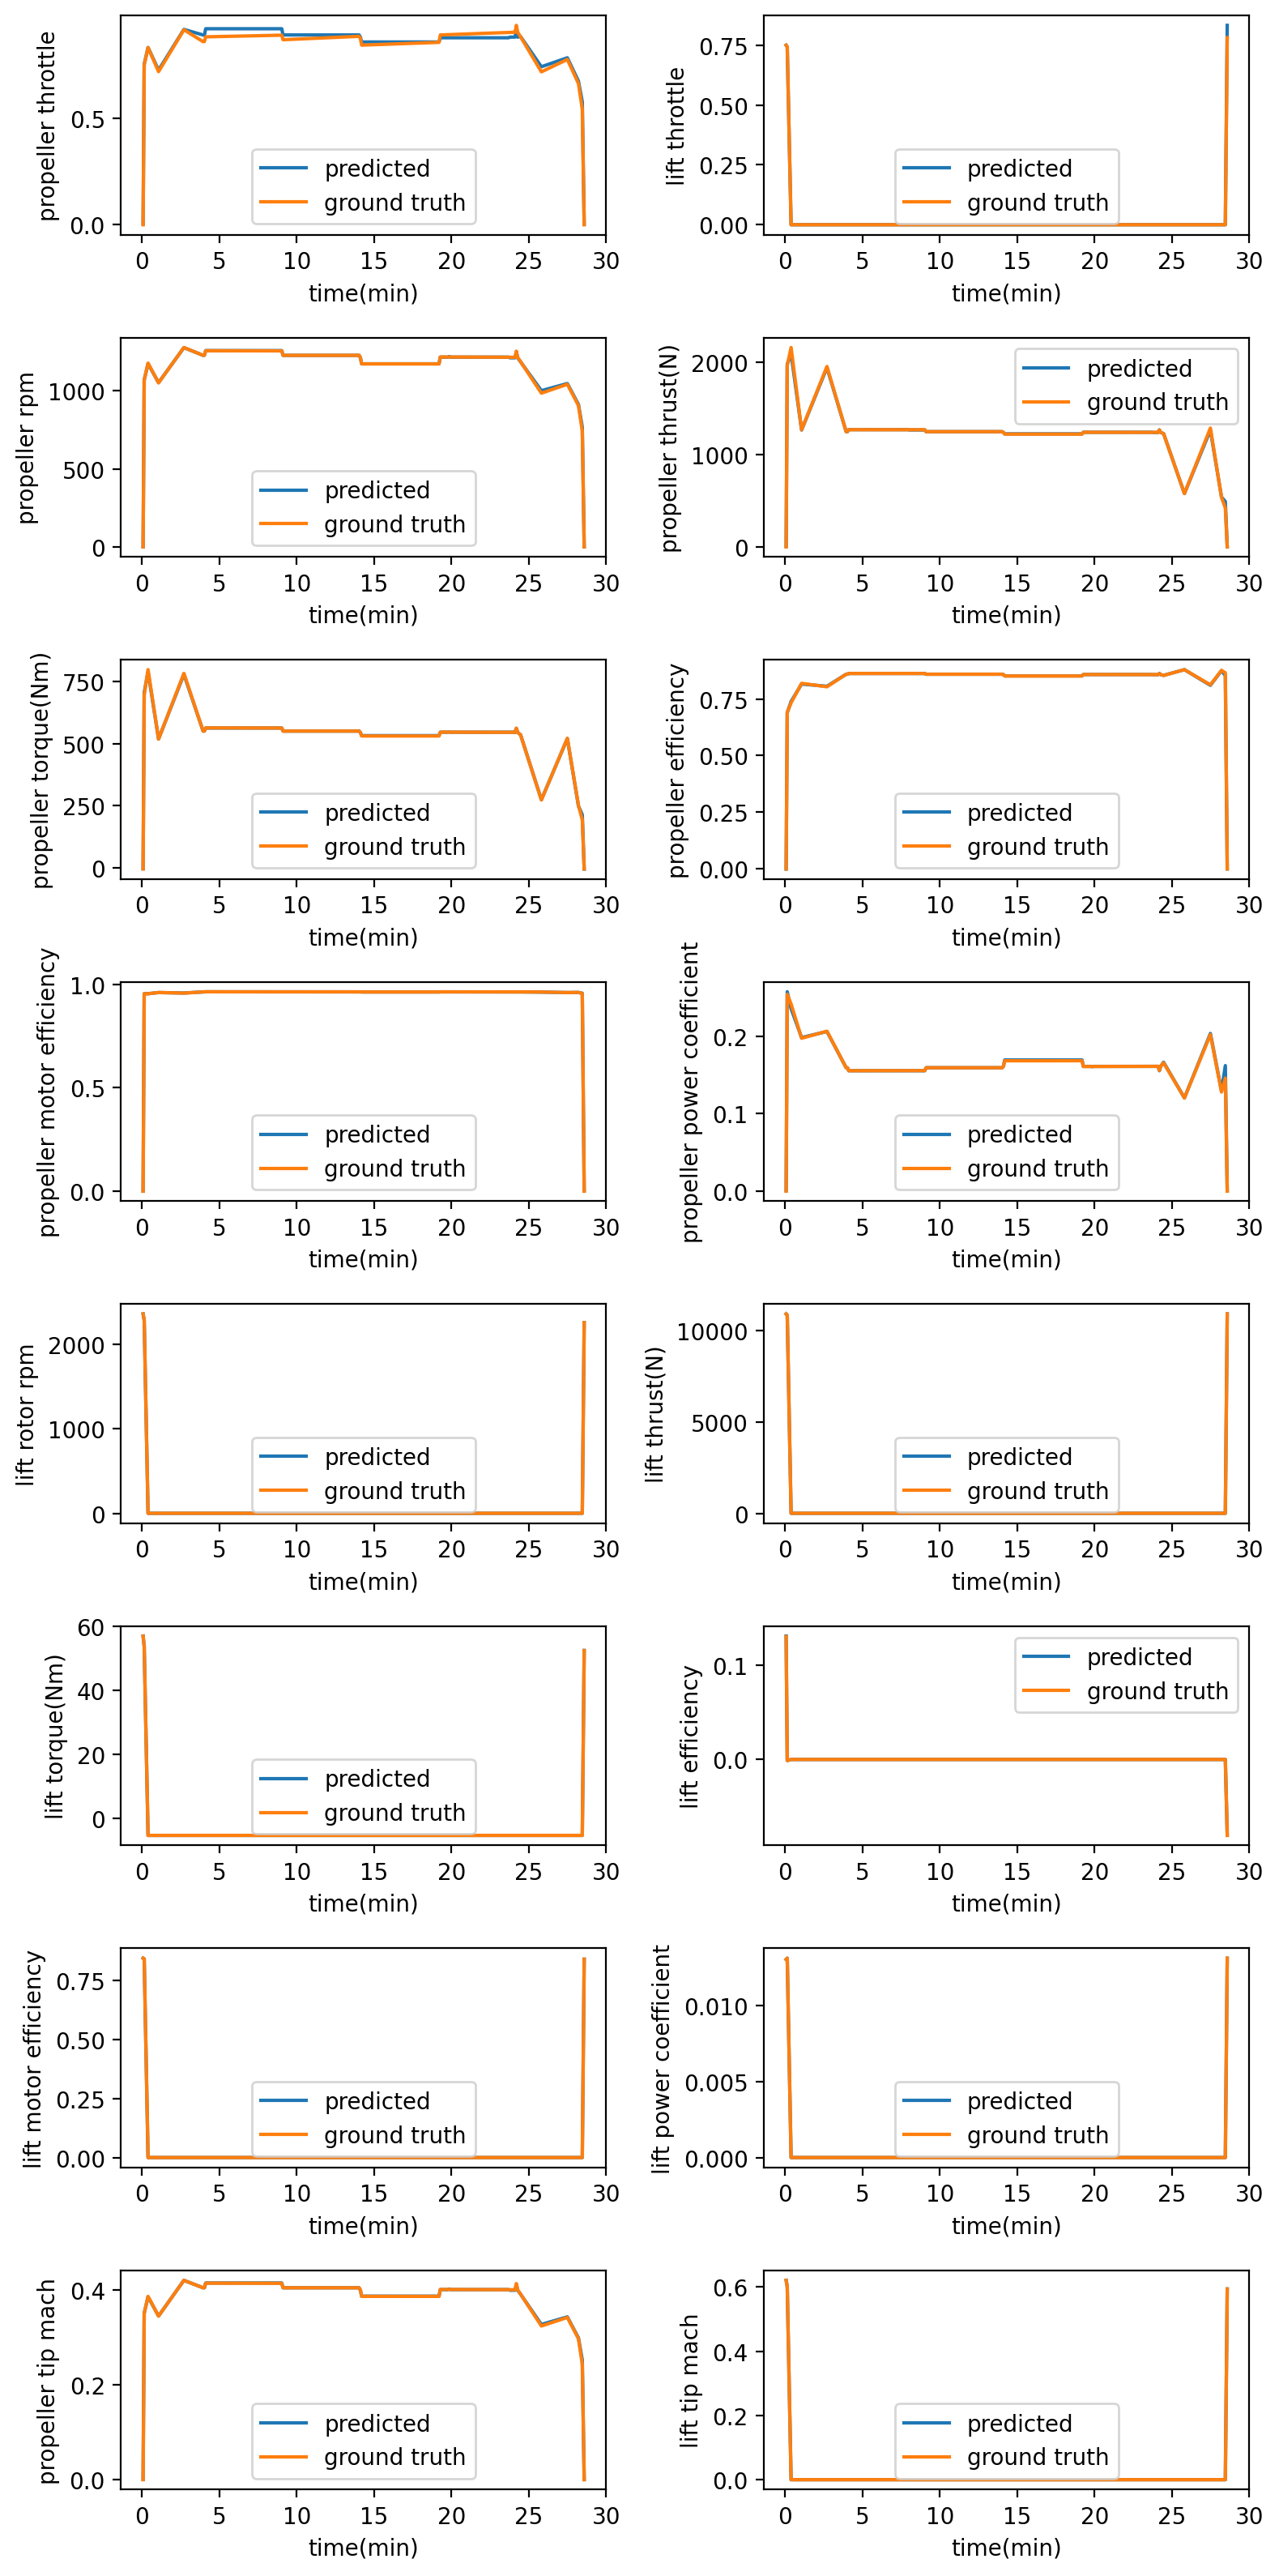

In [96]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('electric_motor_and_propeller_efficiencies')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]):#,17]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = GradientBoostingRegressor(random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['GBoost']['electric_motor_and_propeller_efficiencies']:
            result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]] = {}
            result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
t = testY[:,16]
true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
fig = plt.figure(figsize=(8,16), dpi=200)
for i in range(1,17):
    plt.subplot(8,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# RandomForestRegressor

# Flight Conditions

In [32]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = RandomForestClassifier(max_depth=8, random_state=0)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['RF']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['RF']['fesibility']['f1'] = round(f1, 2)
fesibility_result['RF']['fesibility']['precision'] = round(precision, 2)
fesibility_result['RF']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9947159841479525


(5687, 22)
(5687, 6)
0.0
0.0301
0.0176
173.4148
[RandomForestRegressor(max_depth=8, random_state=0), RandomForestRegressor(max_depth=8, random_state=0), RandomForestRegressor(max_depth=8, random_state=0), RandomForestRegressor(max_depth=8, random_state=0)]
(46, 22) (46, 6)


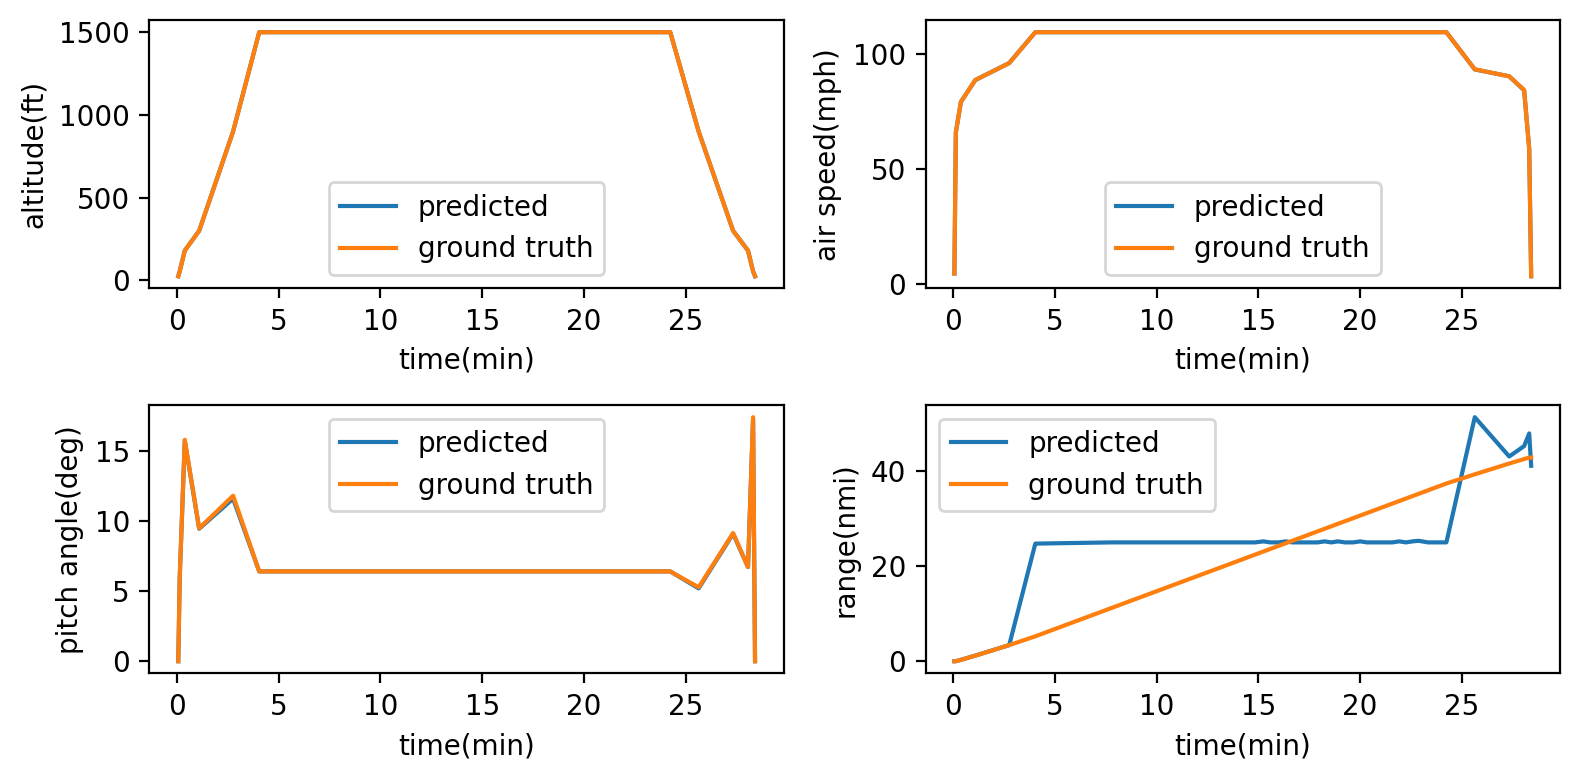

In [128]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('flight_conditions')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = RandomForestRegressor(max_depth=8, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['RF']['flight_conditions']:
            result['RF']['flight_conditions'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['RF']['flight_conditions'][outputs[output_indx]] = {}
            result['RF']['flight_conditions'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('flight_conditions')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
t = testY[:,4]
true_i = [0,1,2,3]#,5]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# Aerodynamic Coefficients

(5687, 22)
(5687, 6)
0.0
0.0
0.0124
0.0003
[RandomForestRegressor(max_depth=8, random_state=0), RandomForestRegressor(max_depth=8, random_state=0), RandomForestRegressor(max_depth=8, random_state=0), RandomForestRegressor(max_depth=8, random_state=0)]
(16, 22) (16, 6)
(16, 6) (16, 4)


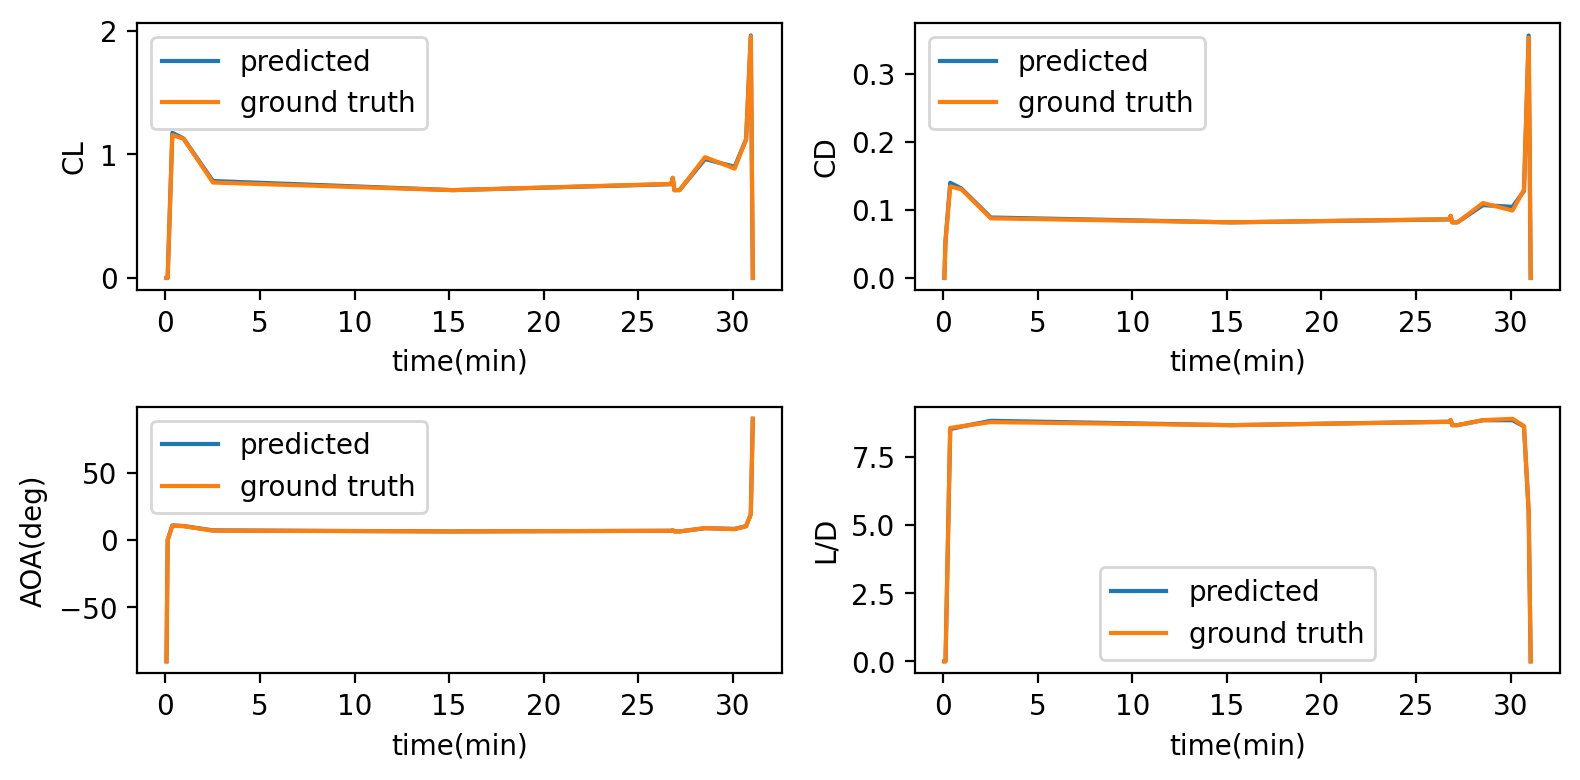

In [99]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('aerodynamic_coefficients')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = RandomForestRegressor(max_depth=8, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['RF']['aerodynamic_coefficients']:
            result['RF']['aerodynamic_coefficients'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['RF']['aerodynamic_coefficients'][outputs[output_indx]] = {}
            result['RF']['aerodynamic_coefficients'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('aerodynamic_coefficients')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
t = testY[:,4]
true_i = [0,1,2,3]#,5]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# Aircraft Electronics

(5687, 22)
(5687, 11)
0.0136
119.1805
0.2506
151.1949
133.9743
27.9842
0.059
0.0585
1.0023
[RandomForestRegressor(max_depth=8, random_state=0), RandomForestRegressor(max_depth=8, random_state=0), RandomForestRegressor(max_depth=8, random_state=0), RandomForestRegressor(max_depth=8, random_state=0), RandomForestRegressor(max_depth=8, random_state=0), RandomForestRegressor(max_depth=8, random_state=0), RandomForestRegressor(max_depth=8, random_state=0), RandomForestRegressor(max_depth=8, random_state=0), RandomForestRegressor(max_depth=8, random_state=0)]
(19, 22) (19, 11)
(19, 11) (19, 9)


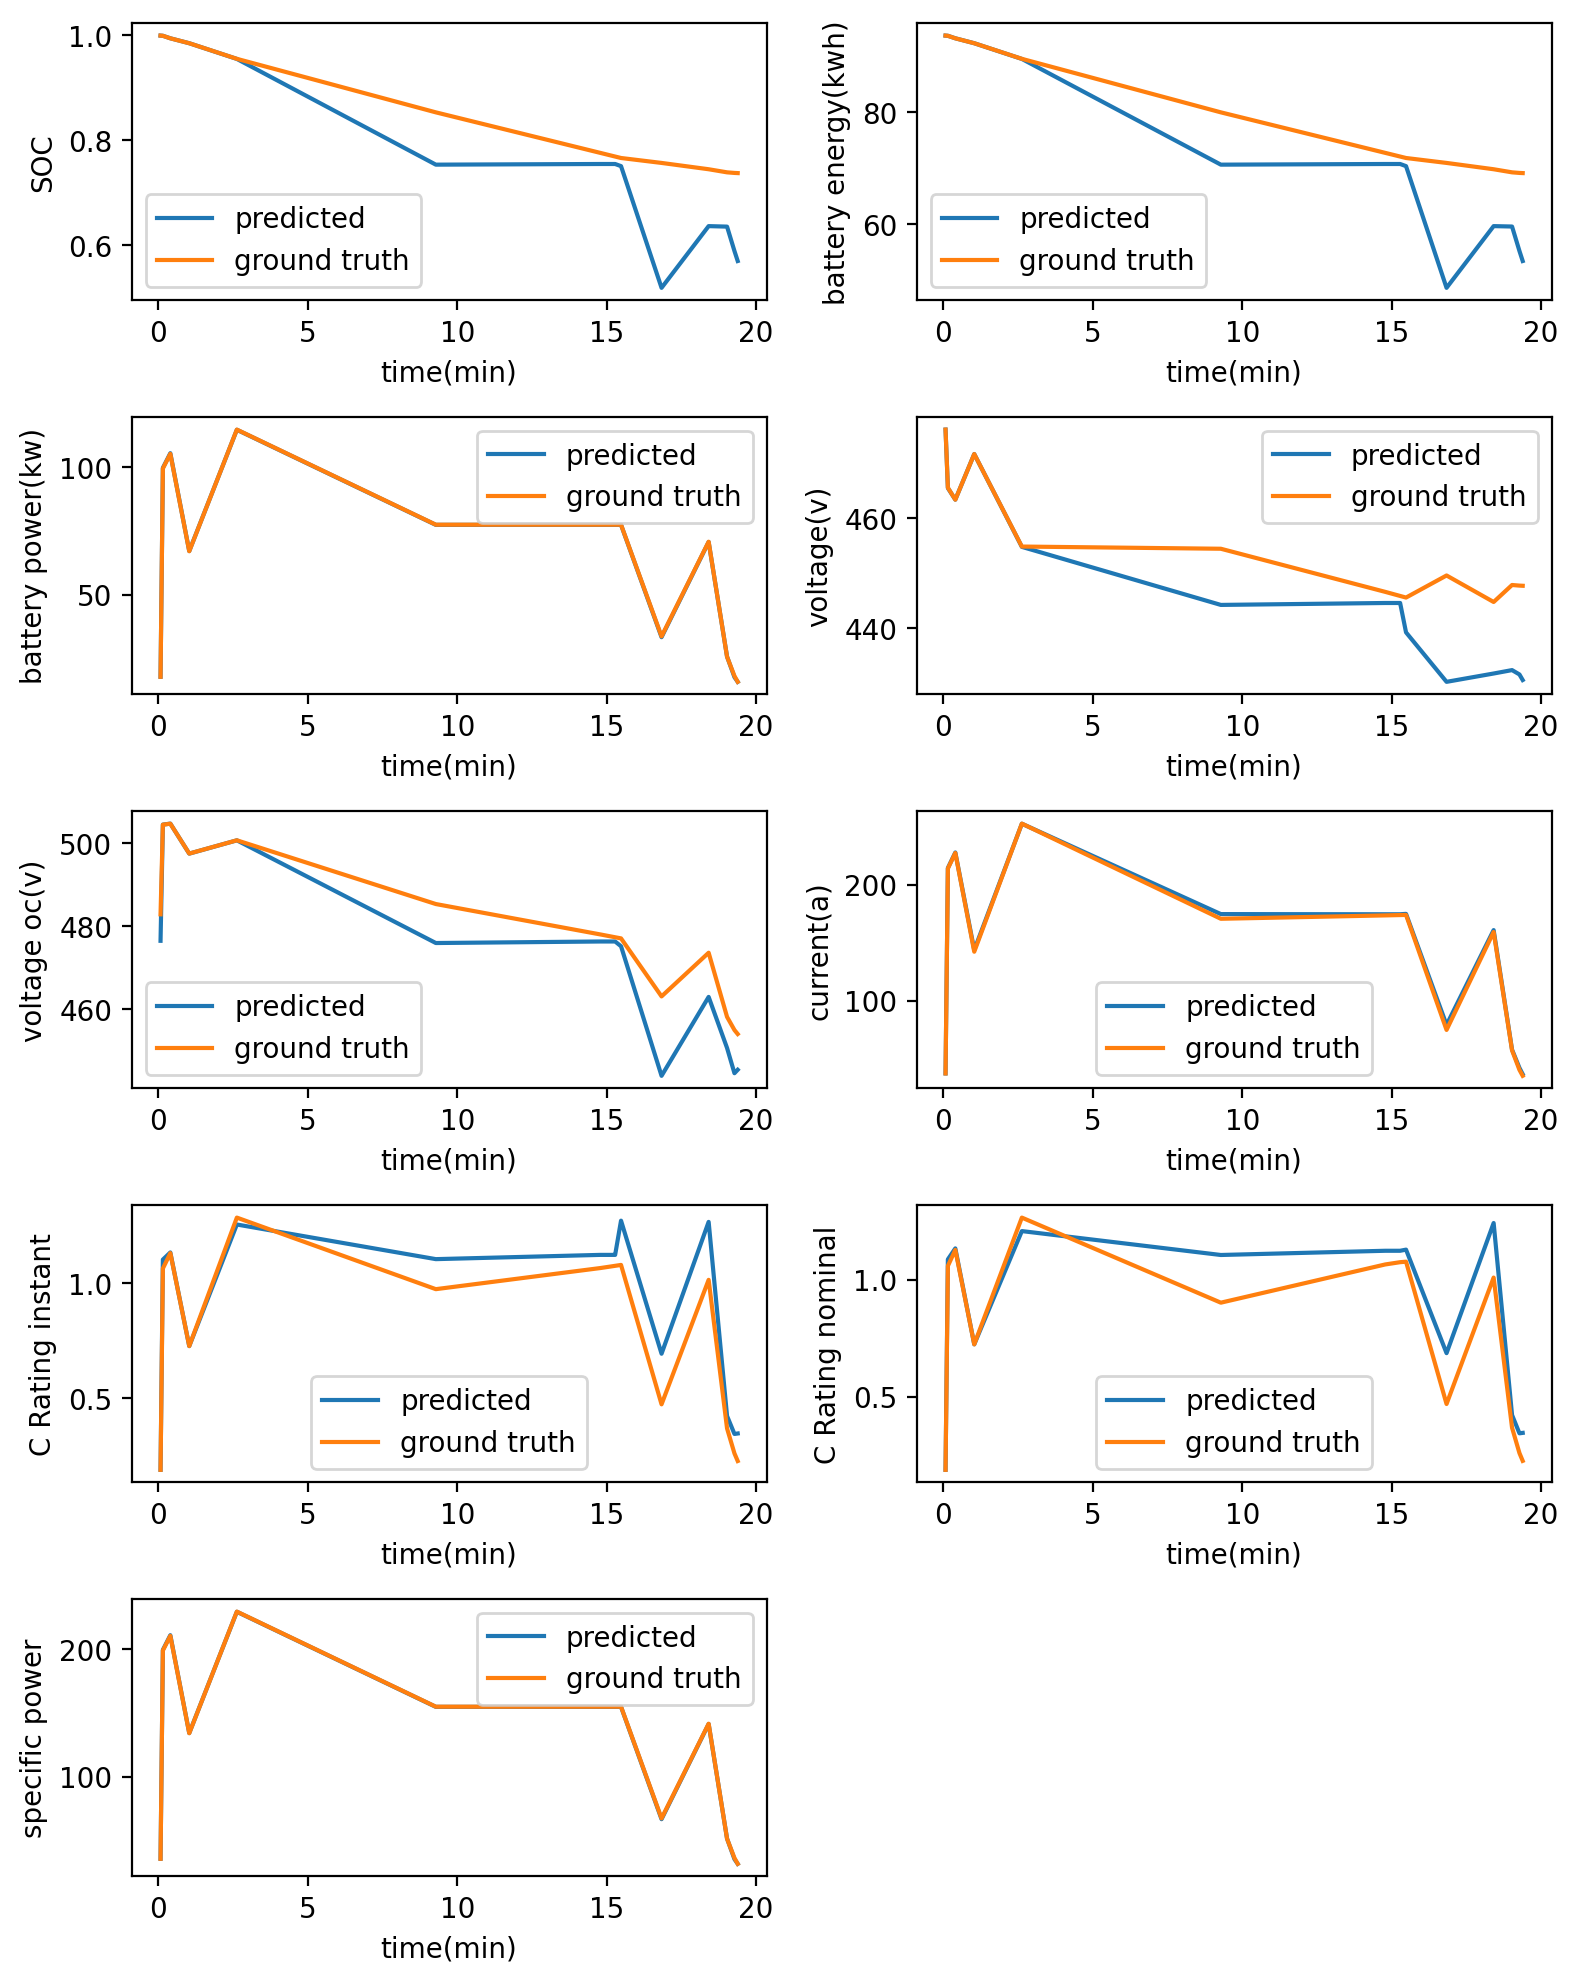

In [100]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('aircraft_electronics')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8]):#,10]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = RandomForestRegressor(max_depth=8, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['RF']['aircraft_electronics']:
            result['RF']['aircraft_electronics'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['RF']['aircraft_electronics'][outputs[output_indx]] = {}
            result['RF']['aircraft_electronics'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('aircraft_electronics')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
t = testY[:,9]
true_i = [0,1,2,3,4,5,6,7,8]#,10]
fig = plt.figure(figsize=(8,10), dpi=200)
for i in range(1,10):
    plt.subplot(5,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# Electric motor and propeller efficiencies

(5687, 22)
(5687, 18)
0.0007
0.0
16.8554
347.1965
23.2701
0.0
0.0
0.0
0.0032
0.0035
0.0
0.0
0.0
0.0
0.0
0.0
[GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0), GradientBoostingRegressor(random_state=0)]
(261, 22) (261, 18)
(261, 18) (261, 16)


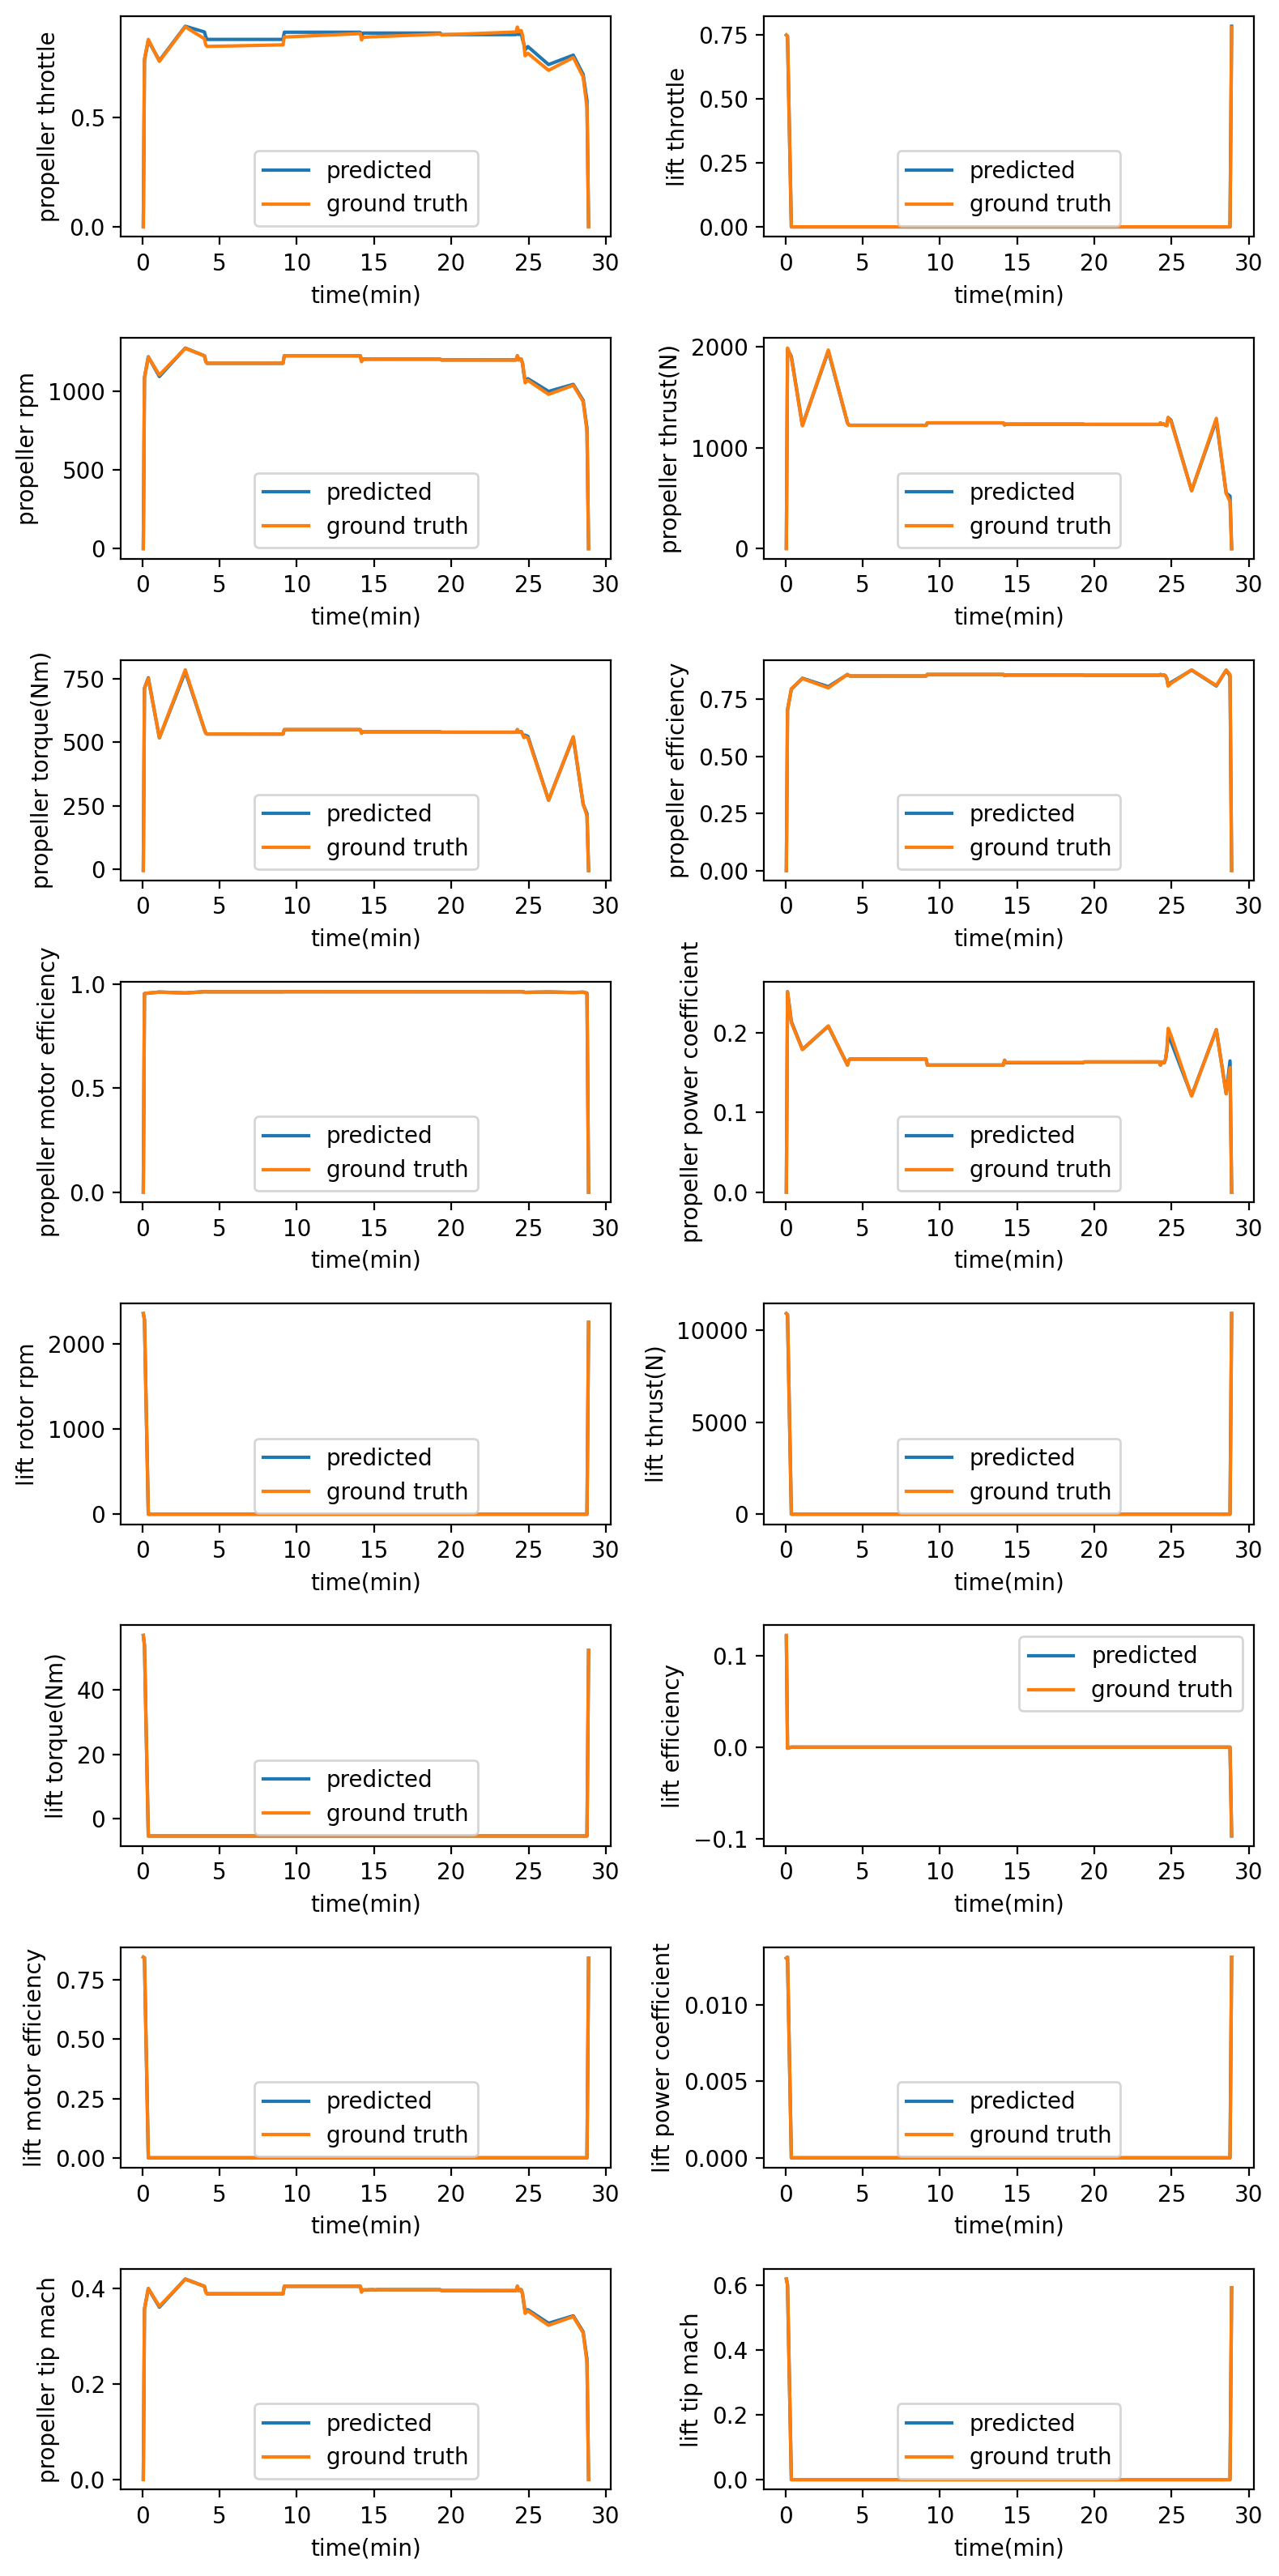

In [101]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('electric_motor_and_propeller_efficiencies')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]):#,17]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = GradientBoostingRegressor(random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['RF']['electric_motor_and_propeller_efficiencies']:
            result['RF']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['RF']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]] = {}
            result['RF']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
t = testY[:,16]
true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
fig = plt.figure(figsize=(8,16), dpi=200)
for i in range(1,17):
    plt.subplot(8,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# SVR

# Flight Conditions

In [31]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = svm.SVC()
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['SVC']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['SVC']['fesibility']['f1'] = round(f1, 2)
fesibility_result['SVC']['fesibility']['precision'] = round(precision, 2)
fesibility_result['SVC']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9920739762219286


(5687, 22)
(5687, 6)
64953.5315
149.4585
3.1902
242.5931
[SVR(), SVR(), SVR(), SVR()]
(29, 22) (29, 6)


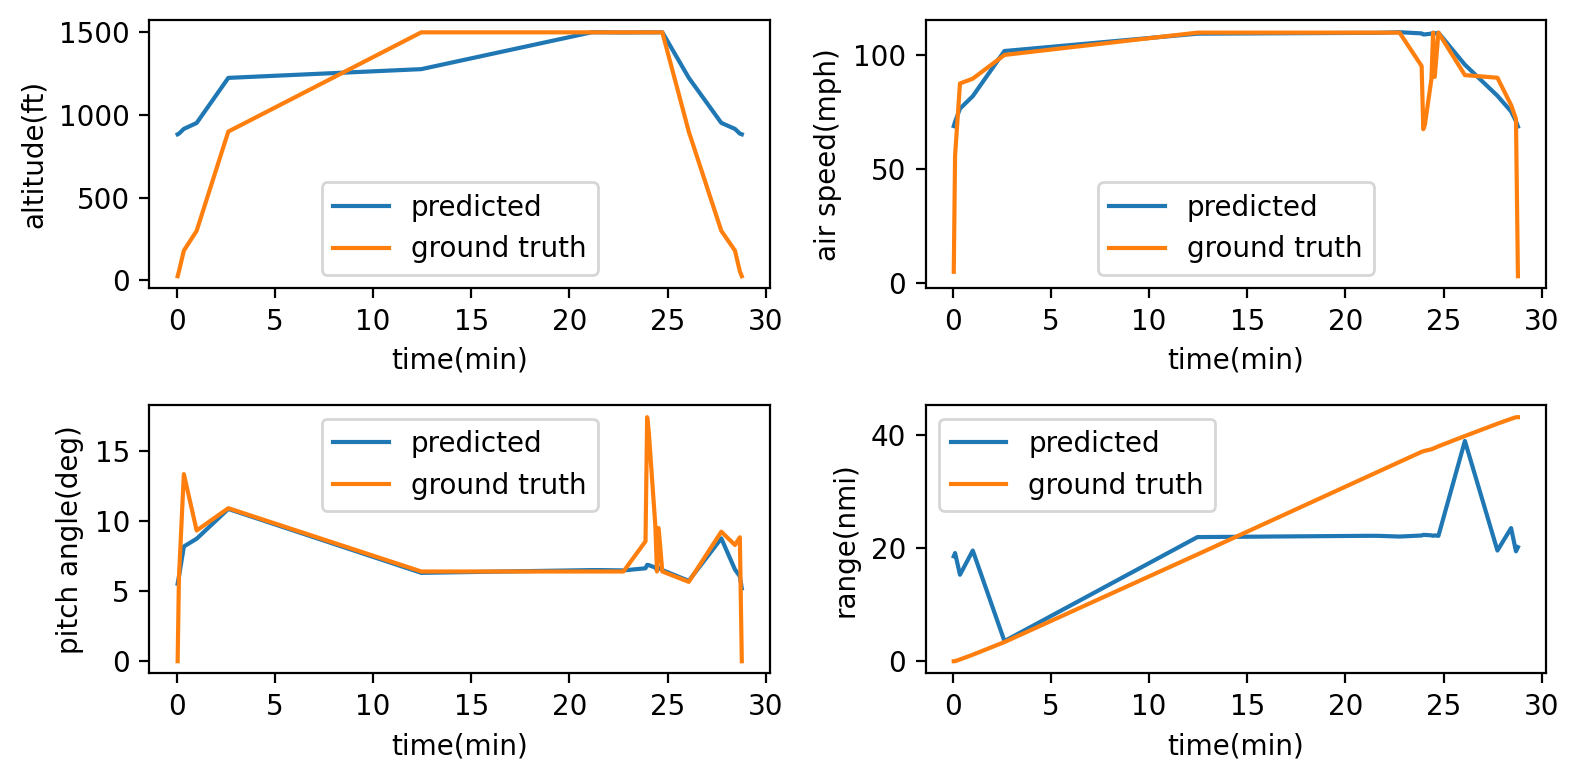

In [130]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('flight_conditions')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = svm.SVR()
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['SVR']['flight_conditions']:
            result['SVR']['flight_conditions'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['SVR']['flight_conditions'][outputs[output_indx]] = {}
            result['SVR']['flight_conditions'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('flight_conditions')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
t = testY[:,4]
true_i = [0,1,2,3]#,5]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# MLP

# Flight Conditions

In [33]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = MLPClassifier(hidden_layer_sizes=(128, 256, 512, 256, 128, ), 
                        random_state=1, 
                        max_iter=1000, 
                        learning_rate='adaptive',
                        verbose=False)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['MLP']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['MLP']['fesibility']['f1'] = round(f1, 2)
fesibility_result['MLP']['fesibility']['precision'] = round(precision, 2)
fesibility_result['MLP']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9920739762219286


(5687, 22)
(5687, 6)
6.7906
0.1543
0.015
179.1826
[MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1)]
(23, 22) (23, 6)


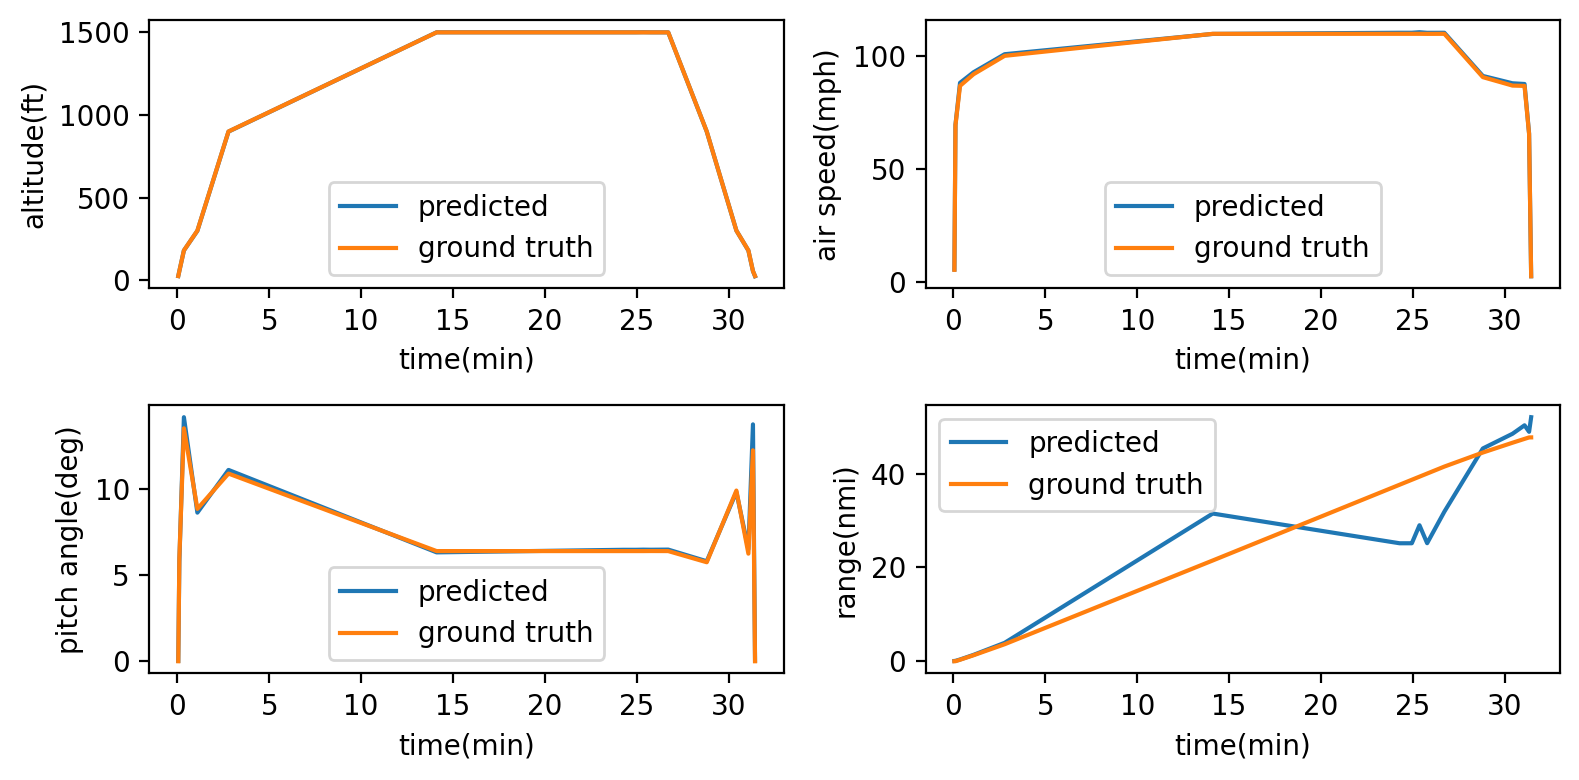

In [134]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('flight_conditions')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
scalers = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    scaler = StandardScaler() 
    scaler.fit(train_X)  
    train_X = scaler.transform(train_X) 
    scalers.append(scaler)
    
    regr = MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128, ), 
                        random_state=1, 
                        max_iter=1000, 
                        learning_rate='adaptive',
                        verbose=False)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['MLP']['flight_conditions']:
            result['MLP']['flight_conditions'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['MLP']['flight_conditions'][outputs[output_indx]] = {}
            result['MLP']['flight_conditions'][outputs[output_indx]][criterias_lst[j]] = err
        
print(best_estimators)

testX, testY = get_data_for_inference('flight_conditions')
print(testX.shape, testY.shape)

pred_Y = None
for i,estimator in enumerate(best_estimators):
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    test_X = scalers[i].transform(testX)
    pred_y = estimator.predict(test_X)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
t = testY[:,4]
true_i = [0,1,2,3]#,5]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# Aerodynamic Coefficients

(5687, 22)
(5687, 6)
0.0004
0.0002
0.2474
0.0023
[MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1)]
(256, 22) (256, 6)
(256, 6) (256, 4)


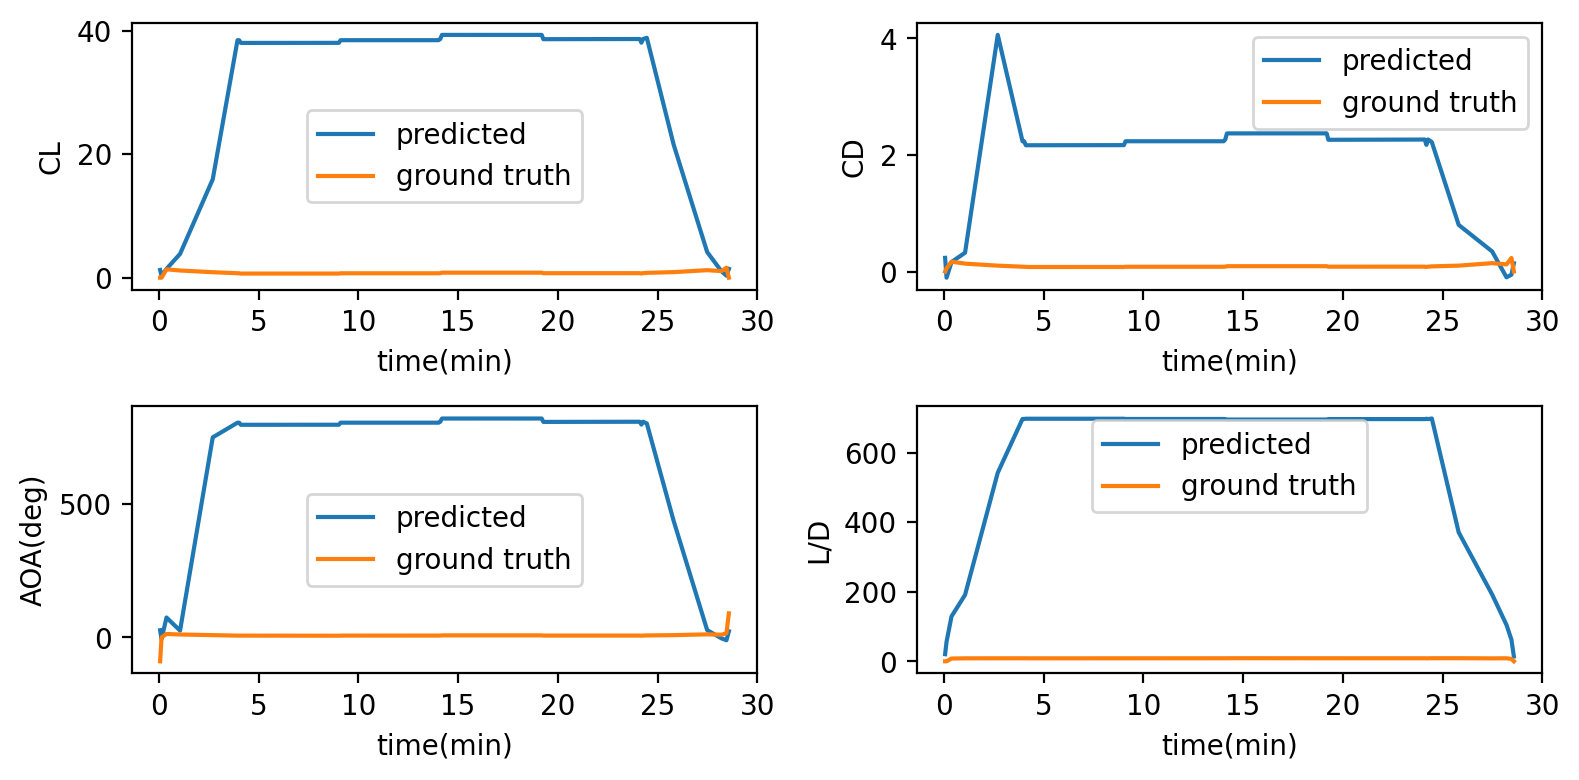

In [113]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('aerodynamic_coefficients')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
scalers = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
        
    scaler = StandardScaler() 
    scaler.fit(train_X)  
    train_X = scaler.transform(train_X) 
    scalers.append(scaler)
    
    regr = MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128, ), 
                        random_state=1, 
                        max_iter=1000, 
                        learning_rate='adaptive',
                        verbose=False)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['MLP']['aerodynamic_coefficients']:
            result['MLP']['aerodynamic_coefficients'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['MLP']['aerodynamic_coefficients'][outputs[output_indx]] = {}
            result['MLP']['aerodynamic_coefficients'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('aerodynamic_coefficients')
print(testX.shape, testY.shape)
pred_Y = None
for i,estimator in enumerate(best_estimators):
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    test_X = scalers[i].transform(testX)
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
t = testY[:,4]
true_i = [0,1,2,3]#,5]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# Aircraft Electronics

(5687, 22)
(5687, 11)
0.0141
126.7662
0.1585
161.7594
136.1473
28.1845
0.0579
0.056
3.3224
[MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1)

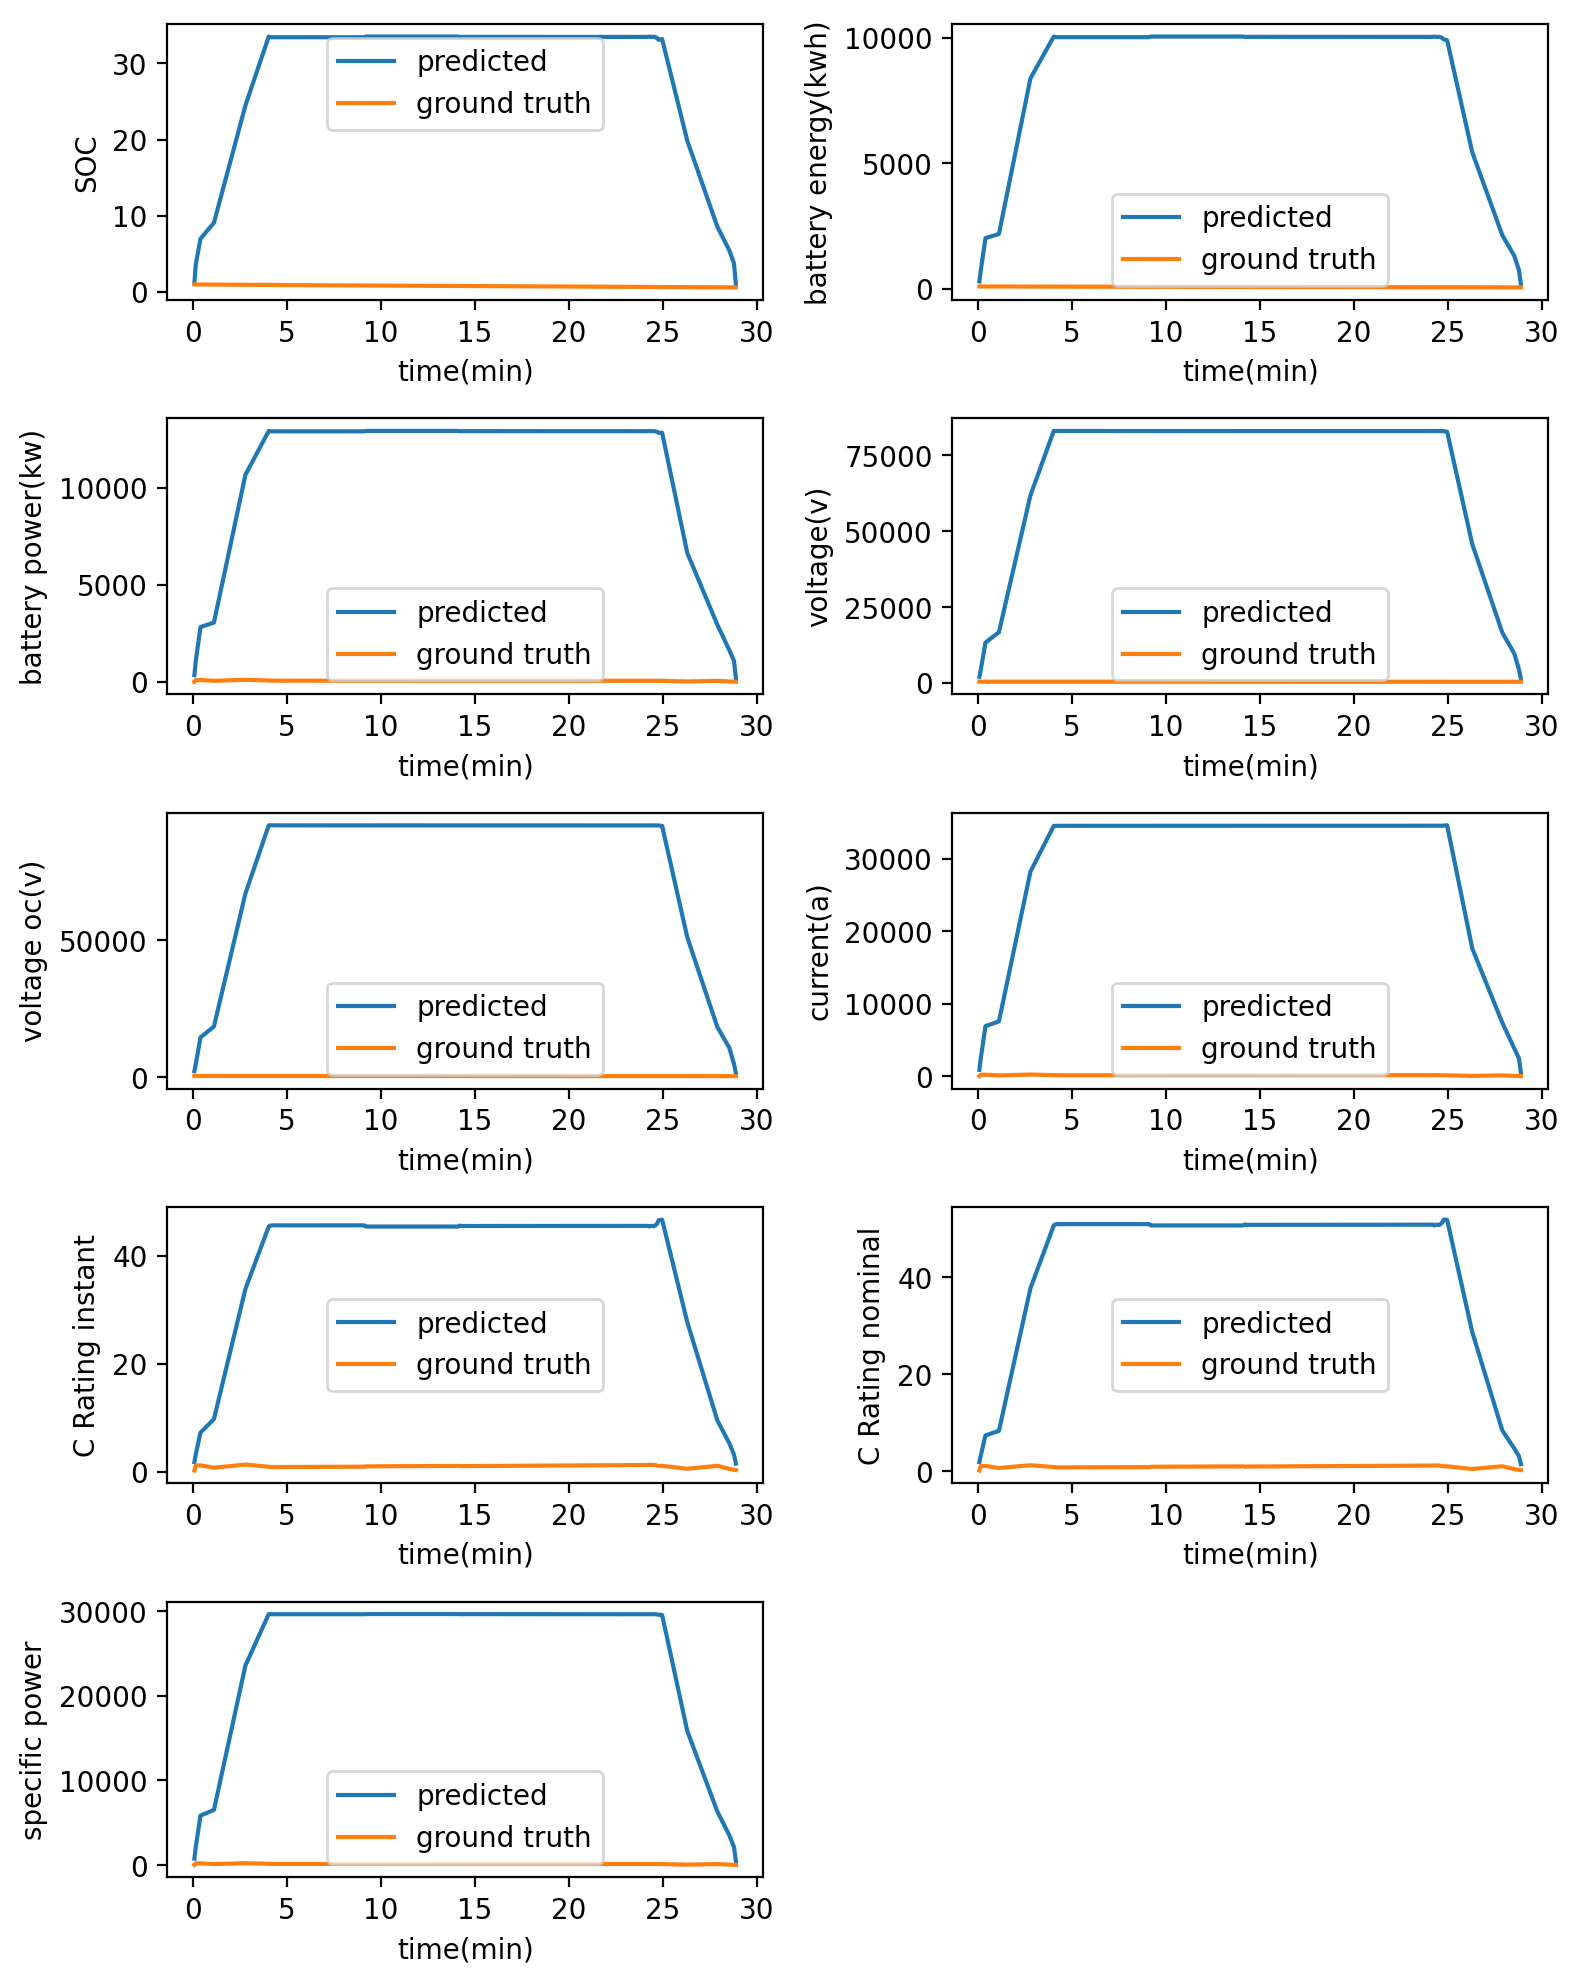

In [114]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('aircraft_electronics')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
scalers = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8]):#,10]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    scaler = StandardScaler() 
    scaler.fit(train_X)  
    train_X = scaler.transform(train_X) 
    scalers.append(scaler)
    regr = MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128, ), 
                        random_state=1, 
                        max_iter=1000, 
                        learning_rate='adaptive',
                        verbose=False)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['MLP']['aircraft_electronics']:
            result['MLP']['aircraft_electronics'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['MLP']['aircraft_electronics'][outputs[output_indx]] = {}
            result['MLP']['aircraft_electronics'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('aircraft_electronics')
print(testX.shape, testY.shape)
pred_Y = None
for i, estimator in enumerate(best_estimators):
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    test_X = scalers[i].transform(testX)
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
t = testY[:,9]
true_i = [0,1,2,3,4,5,6,7,8]#,10]
fig = plt.figure(figsize=(8,10), dpi=200)
for i in range(1,10):
    plt.subplot(5,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# Electric motor and propeller efficiencies

(5687, 22)
(5687, 18)
0.0009
0.0
61.9267
216.2518
21.3458
0.0001
0.0
0.0
227.8191
364.8297
0.0312
0.0
0.0
0.0
0.0
0.0
[MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max

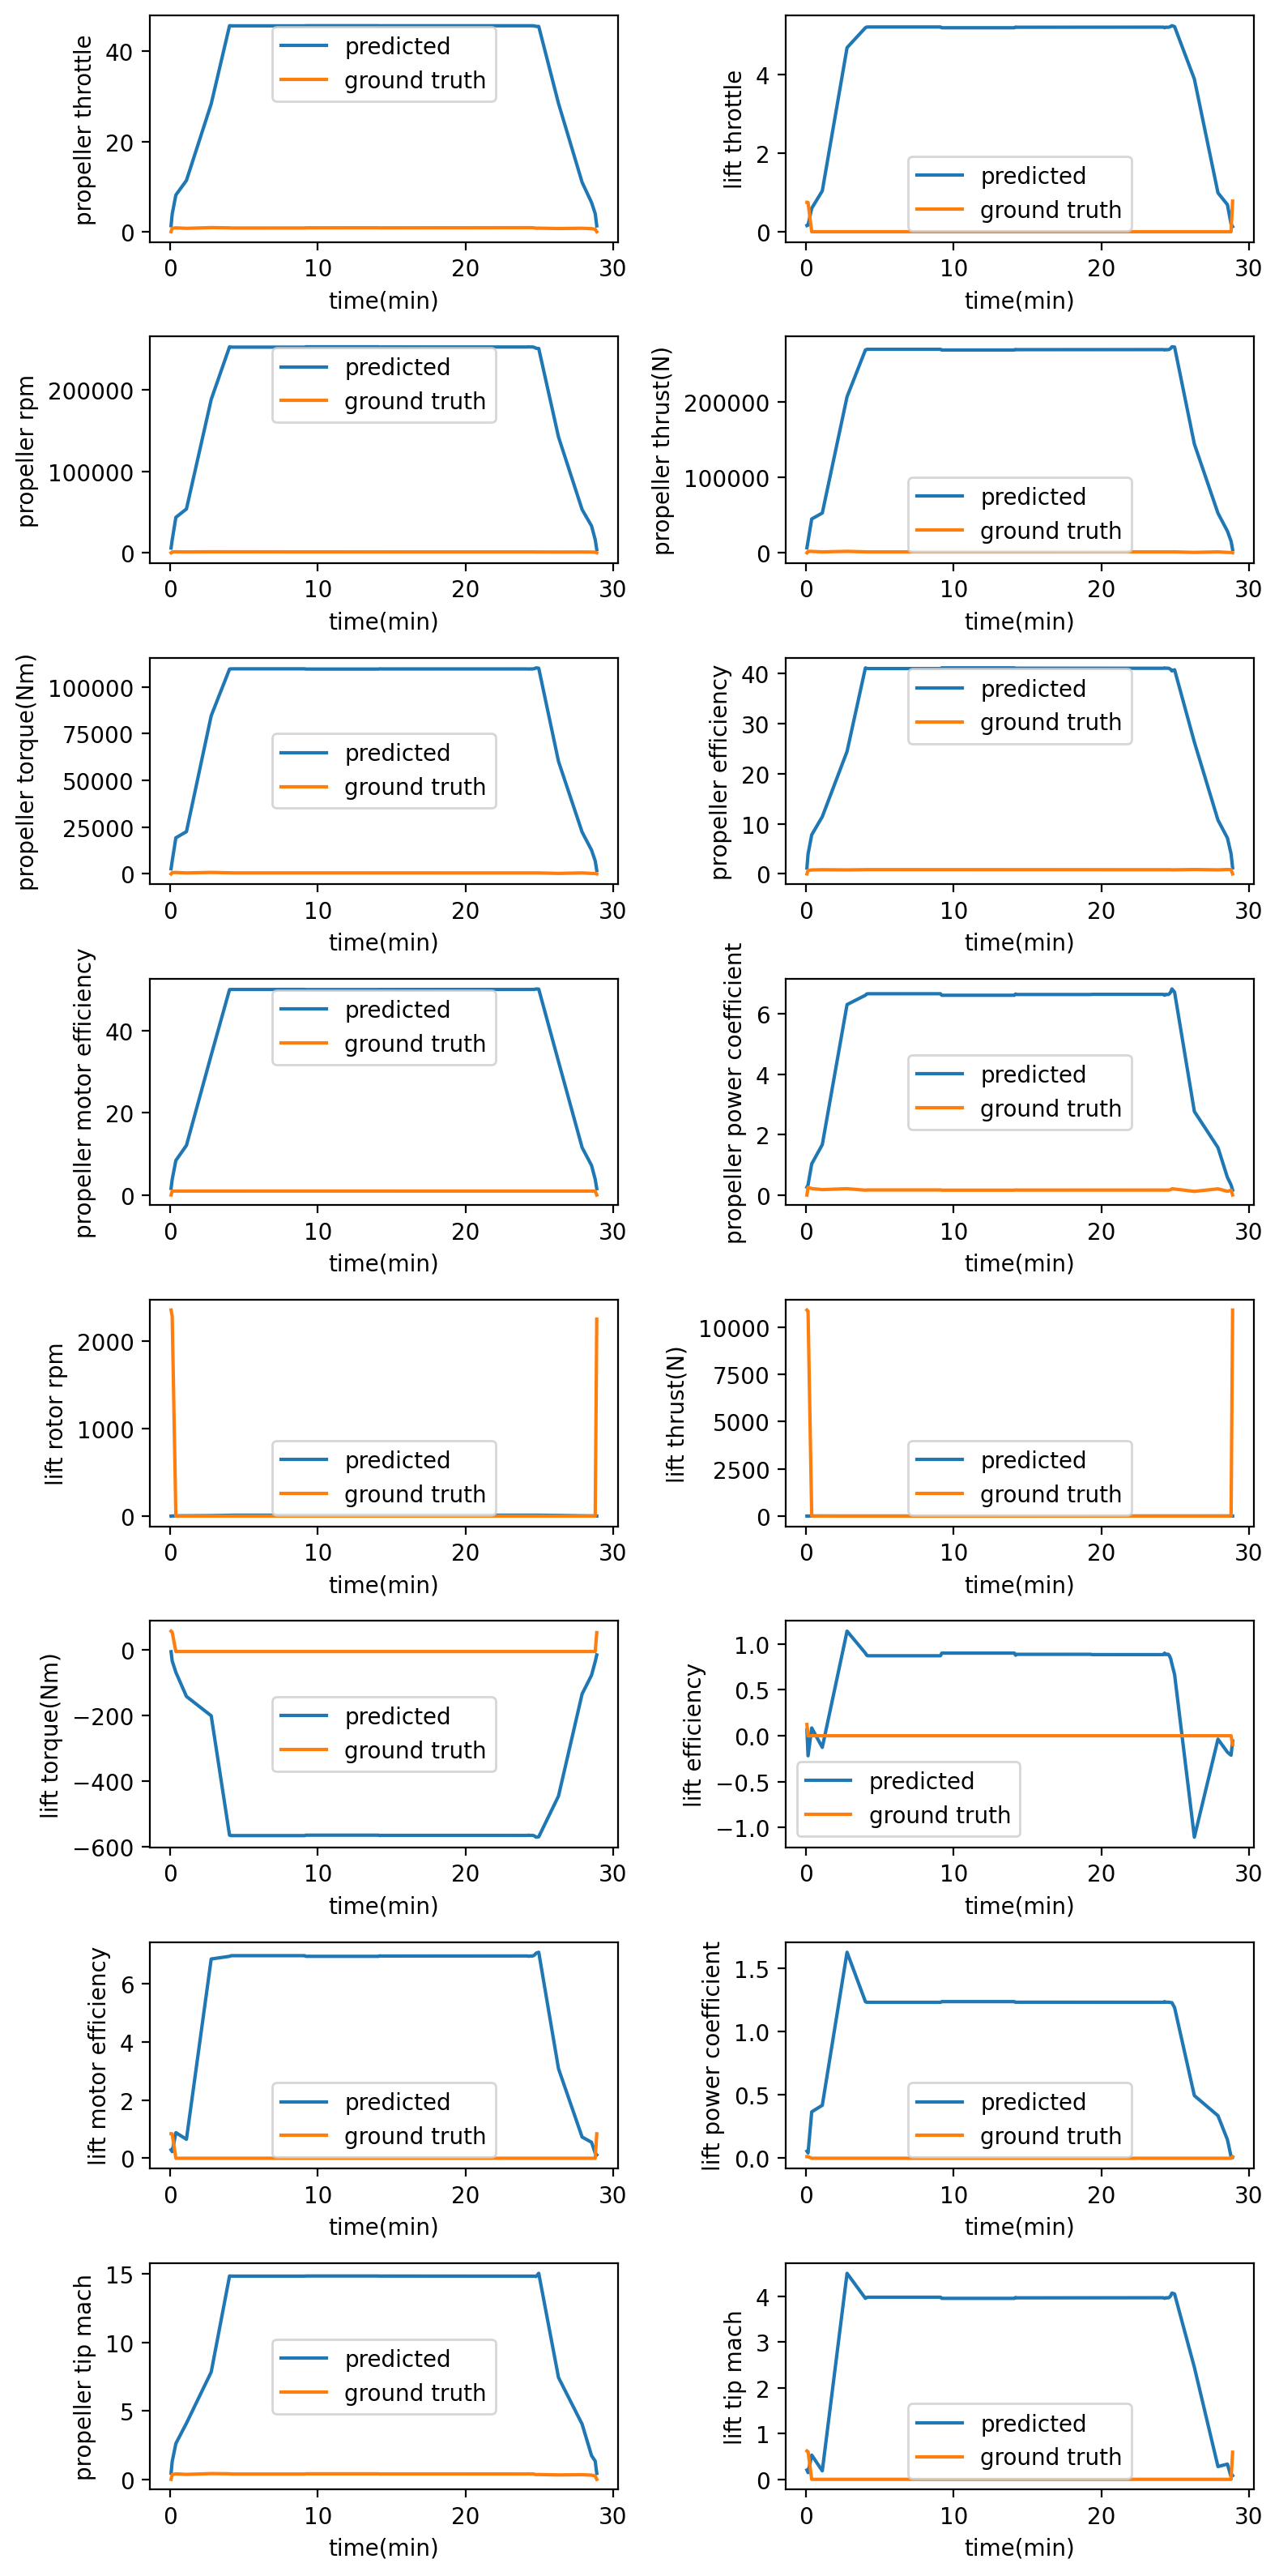

In [115]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('electric_motor_and_propeller_efficiencies')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
scalers = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]):#,17]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    scaler = StandardScaler() 
    scaler.fit(train_X)  
    train_X = scaler.transform(train_X) 
    scalers.append(scaler)
    regr = MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128, ), 
                        random_state=1, 
                        max_iter=1000, 
                        learning_rate='adaptive',
                        verbose=False)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['MLP']['electric_motor_and_propeller_efficiencies']:
            result['MLP']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['MLP']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]] = {}
            result['MLP']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
print(testX.shape, testY.shape)
pred_Y = None
for i,estimator in enumerate(best_estimators):
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    test_X = scalers[i].transform(testX)
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
t = testY[:,16]
true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
fig = plt.figure(figsize=(8,16), dpi=200)
for i in range(1,17):
    plt.subplot(8,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# LSTM

# Flight Conditions

In [ ]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('flight_conditions')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
scalers = []
for i in [0,1,2,5]:
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    scaler = StandardScaler() 
    scaler.fit(train_X)  
    train_X = scaler.transform(train_X) 
    scalers.append(scaler)
    
    regr = MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128, ), 
                        random_state=1, 
                        max_iter=1000, 
                        learning_rate='adaptive',
                        verbose=False)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
print(best_estimators)

testX, testY = get_data_for_inference('flight_conditions')
print(testX.shape, testY.shape)

pred_Y = None
for i,estimator in enumerate(best_estimators):
    test_X = scalers[i].transform(testX)
    pred_y = estimator.predict(test_X)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'fesibility']
t = testY[:,4]
true_i = [0,1,2,5]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).float() #hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).float() #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
#         hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
#         out = self.relu(hn)
        output = output.view(-1, self.hidden_size)
        out = self.relu(output)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [ ]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')

mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(dataX)
y_mm = mm.fit_transform(dataY[:,3].reshape(-1, 1)) 

num_epochs = 5000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 22 #number of features
hidden_size = 32 #number of features in hidden state
num_layers = 4 #number of stacked lstm layers
seq_length = 1
num_classes = 1 #number of output classes

In [ ]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, seq_length) #our lstm class 
print(lstm1)  

In [ ]:
criterion = torch.nn.MSELoss()   
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 
for epoch in range(num_epochs+1):
    err_in_epoch = []
    for X,Y in get_data_for_lstm('flight_conditions'):
        indxes = Y[:,-1]==1
        y = Y[indxes][:,3]
        train_X = X[indxes]
        X_ss = ss.transform(train_X)
        y_mm = mm.transform(y.reshape(-1, 1)) 
        
        X_train_tensors = torch.tensor(X_ss).float()
        y_train_tensors = torch.tensor(y_mm).float()

        X_train_tensors_final = torch.reshape(X_train_tensors,   
                                              (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
        
        
        outputs = lstm1.forward(X_train_tensors_final) 
        optimizer.zero_grad() 
        loss = criterion(outputs, y_train_tensors)
        loss.backward() 
        optimizer.step()
        err_in_epoch.append(loss.item())
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, np.mean(err_in_epoch))) 

In [ ]:
mm.inverse_transform([[0.02267]])

In [ ]:
testX, testY = get_data_for_inference('flight_conditions')
print(testX.shape, testY.shape)

X_ss = ss.transform(testX)
y_mm = mm.transform(testY[:,3].reshape(-1, 1))
y_true = testY[:,3]

X_train_tensors = torch.tensor(X_ss).float()
y_train_tensors = torch.tensor(y_mm).float()

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
outputs = lstm1.forward(X_train_tensors_final) 
outputs = outputs.data.numpy()
y_pred = mm.inverse_transform(outputs).squeeze()
print(y_pred.shape)
print(y_true.shape)
plt.plot(y_pred)
plt.plot(y_true)
print(mean_squared_error(y_true,y_pred))
print(mean_squared_error(y_mm.squeeze(), outputs.squeeze()))

# pred_Y = None
# for i,estimator in enumerate(best_estimators):
#     test_X = scalers[i].transform(testX)
#     pred_y = estimator.predict(test_X)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# # print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'fesibility']
# t = testY[:,4]
# true_i = [0,1,2,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

# show results

# Feasibility Classifier Scores

In [34]:
for key in fesibility_result:
    fes_rslt_df = pd.DataFrame.from_dict(fesibility_result[key])
    print('**********')
    print(key)
    print(fes_rslt_df)

**********
DT
           fesibility
accuracy         0.99
f1               1.00
precision        0.99
recall           1.00
**********
ADBoost
Empty DataFrame
Columns: [fesibility]
Index: []
**********
GBoost
           fesibility
accuracy         0.99
f1               0.99
precision        0.99
recall           0.99
**********
RF
           fesibility
accuracy         0.99
f1               1.00
precision        0.99
recall           1.00
**********
SVC
           fesibility
accuracy         0.99
f1               1.00
precision        0.99
recall           1.00
**********
MLP
           fesibility
accuracy         0.99
f1               1.00
precision        0.99
recall           1.00
**********
LSTM
Empty DataFrame
Columns: [fesibility]
Index: []


# Regressor Scores

In [135]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['flight_conditions'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MAE            0.0          0.0387            0.0116     12.6842
MSE            0.0          0.0213            0.0049    297.7240
RMSE           0.0          0.1214            0.0584     17.1700
MAPE           0.0          0.0005            0.0013      0.7133
**********
ADBoost
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MAE            0.0          0.0406            0.0278     11.9614
MSE            0.0          0.0215            0.0038    227.6418
RMSE           0.0          0.1224            0.0590     15.0081
MAPE           0.0          0.0005            0.0038      0.7754
**********
GBoost
      altitude(ft)  air speed(mph)  pitch angle(deg)    range(nmi)
MAE         0.0102          0.0882      3.330000e-02  1.004120e+01
MSE         0.0022          0.0340      1.210000e-02  1.690888e+02
RMSE        0.0349          0.1724      1.063000e-01  1.294170e+01
MAPE        0.0001          0.0